# Desafio: Construção de um modelo supervisionado buscando minimizar o risco de crédito para o financiamento de veículos.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import math

warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [ ]:
df_origem = pd.read_csv('case_cientista_dados_PAN.txt',sep=';')

### Limpeza e Transformação dos dados

In [ ]:
df_origem_=df_origem.copy()

In [ ]:
df_origem_.shape

(7000, 11)

In [ ]:
df_origem_.head(5)

,CLIENTE,DATA_FINANCIAMENTO,TARGET_M3OVER30,IDADE,ESTADO,RENDA,LIMITE_CARTAO,VALOR_FINANC_VEICULOS_ATUAL,SCORE_MERCADO,VALOR_VEICULO,ANO_VEICULO
0,0,2021-10,1,25.0,SP,4760.043944,21361.878421,0.000000,882.238536,"27802,51",2020.0
1,1,2021-11,1,27.0,CE,1700.000000,6551.924996,0.000000,956.692365,"34525,51",2020.0
2,2,2021-10,1,32.0,RJ,4004.147555,12831.296653,29246.823466,610.724337,"36178,14",2020.0
3,3,2021-12,1,39.0,CE,12250.000000,11252.113450,111621.080000,815.069341,"38681,99",2020.0
4,4,2021-12,0,38.0,RJ,1800.000000,11087.609068,0.000000,947.383539,"30742,18",2021.0


In [ ]:
df_origem_['TARGET_M3OVER30'].value_counts(normalize=True)

0    0.714286
1    0.285714
Name: TARGET_M3OVER30, dtype: float64

In [ ]:
df_origem_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CLIENTE                      7000 non-null   int64  
 1   DATA_FINANCIAMENTO           7000 non-null   object 
 2   TARGET_M3OVER30              7000 non-null   int64  
 3   IDADE                        6981 non-null   float64
 4   ESTADO                       7000 non-null   object 
 5   RENDA                        7000 non-null   float64
 6   LIMITE_CARTAO                6934 non-null   float64
 7   VALOR_FINANC_VEICULOS_ATUAL  6934 non-null   float64
 8   SCORE_MERCADO                6980 non-null   float64
 9   VALOR_VEICULO                6997 non-null   object 
 10  ANO_VEICULO                  6997 non-null   float64
dtypes: float64(6), int64(2), object(3)
memory usage: 601.7+ KB


In [ ]:
df_sNAN =df_origem_.dropna(axis=0, how='any')
df_sNAN.shape

(6898, 11)

Apenas as variáveis DATA_FINANCIAMENTO, TARGET_M3OVER30, ESTADO e RENDA estão 100% preenchidas. Como a volumetria de NA's é baixa (1,5%) vamos apenas eliminamos esses registros. Outra opção seria preencher com Mediana ou Moda.

In [ ]:
# VALOR_VEICULO está como object, vamos transformá-la em float
df_sNAN['VALOR_VEICULO'] = df_sNAN['VALOR_VEICULO'].str.replace(',','.').astype(float)

In [ ]:
df_sNAN.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 6999
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CLIENTE                      6898 non-null   int64  
 1   DATA_FINANCIAMENTO           6898 non-null   object 
 2   TARGET_M3OVER30              6898 non-null   int64  
 3   IDADE                        6898 non-null   float64
 4   ESTADO                       6898 non-null   object 
 5   RENDA                        6898 non-null   float64
 6   LIMITE_CARTAO                6898 non-null   float64
 7   VALOR_FINANC_VEICULOS_ATUAL  6898 non-null   float64
 8   SCORE_MERCADO                6898 non-null   float64
 9   VALOR_VEICULO                6898 non-null   float64
 10  ANO_VEICULO                  6898 non-null   float64
dtypes: float64(7), int64(2), object(2)
memory usage: 646.7+ KB


In [ ]:
df_sNAN.describe()

,CLIENTE,TARGET_M3OVER30,IDADE,RENDA,LIMITE_CARTAO,VALOR_FINANC_VEICULOS_ATUAL,SCORE_MERCADO,VALOR_VEICULO,ANO_VEICULO
count,6898.000000,6898.000000,6898.000000,6898.000000,6898.000000,6898.000000,6898.000000,6898.000000,6898.000000
mean,3452.625109,0.283271,43.115251,8238.090355,9027.895528,9023.652035,754.572105,40131.138388,2019.960278
std,2019.619826,0.450619,13.021799,7949.645174,16065.667970,24102.769915,163.730261,7465.196000,1.371065
min,0.000000,0.000000,19.000000,800.000000,0.000000,0.000000,1.462154,16108.130000,2011.000000
25%,1700.250000,0.000000,32.000000,2350.000000,1058.153346,0.000000,641.000000,34979.967500,2020.000000
50%,3437.500000,0.000000,42.000000,5550.000000,5422.618532,0.000000,775.000000,39771.355000,2020.000000
75%,5193.750000,1.000000,53.000000,11875.311412,12592.439606,0.000000,891.072137,44714.402500,2021.000000
max,6999.000000,1.000000,77.000000,106828.787747,709776.920000,367302.807884,999.999903,97177.920000,2021.000000


Pela tabela de descrição do dataframe df_sNAN, é possível notar que não há nenhum valor negativo para ser tratado.
Existe alguns outliers (limite_cartao, renda, valor_veiculo). Pelo menos 75% da base tem VALOR_FINANC_VEICULOS_ATUAL=0

### Separação entre Base de Desenvolvimento do Modelo e base Validação do Modelo

In [ ]:
df_sNAN['DATA_FINANCIAMENTO'].value_counts()

2021-12    2331
2021-10    2312
2021-11    2255
Name: DATA_FINANCIAMENTO, dtype: int64

Temos apenas e 3 meses de dados. Dessa maneiro vamos treinar o modelo com 2 meses e 1 mês para validar. Uma amostragem Out-of-time dá mais robustez ao modelo, pois está mais alinhado com um cenário real.

In [ ]:
# dataset de desenvolvimento
df_dev = df_sNAN[df_sNAN['DATA_FINANCIAMENTO']<'2021-12']

# dataset de validação
df_val = df_sNAN[df_sNAN['DATA_FINANCIAMENTO']=='2021-12']

In [ ]:
# validação se não se perdeu algum dado
df_sNAN.shape[0] == df_dev.shape[0]+df_val.shape[0]

True

### Análise Exploratória

Nessa etapa será estudada cada uma das variáveis. Inicialmente temos 8, sendo 2 qualitativas e 6 quantitativas. Vamos aqui já criar algumas variáveis que podem ajudar na performance do modelo.

In [ ]:
## Variáveis Quantitativas
# LIMITE_CARTAO/RENDA: Quanto o cliente pode está exposto no mercado de crédito,
# se tem um limite maior do que a renda pode ser o cliente mais arriscado
df_dev['LIMITE_CARTAO_RENDA'] = df_dev['LIMITE_CARTAO']/df_dev['RENDA']

# VALOR_VEICULO/RENDA: Quantas vezes o veículo é maior do que a renda,
# uma variável associada a capacidade de pagamento, embora o cliente pode dar uma entrada maior ou menor
df_dev['VALOR_VEICULO_RENDA'] = df_dev['VALOR_VEICULO']/df_dev['RENDA']

# VALOR_VEICULO_RENDA/VALOR_VEICULO: Relação entre o financiamento atual e valor do novo veículo
df_dev['VALOR_FINANC_VEICULOS_ATUAL_VALOR_VEICULO'] = df_dev['VALOR_FINANC_VEICULOS_ATUAL']/df_dev['VALOR_VEICULO']

In [ ]:
df_dev['IDADE_VEICULO'] = df_dev['DATA_FINANCIAMENTO'].str.strip().str.split('-').str[0].astype(int)-df_dev['ANO_VEICULO']

In [ ]:
var_quant = ['IDADE', 'RENDA', 'LIMITE_CARTAO', 'VALOR_FINANC_VEICULOS_ATUAL', 'SCORE_MERCADO', 'VALOR_VEICULO',
             'LIMITE_CARTAO_RENDA', 'VALOR_VEICULO_RENDA', 'VALOR_FINANC_VEICULOS_ATUAL_VALOR_VEICULO','IDADE_VEICULO'
            ]
var_quali = ['ESTADO']

#### Variáveis Quantitativas

Correlação

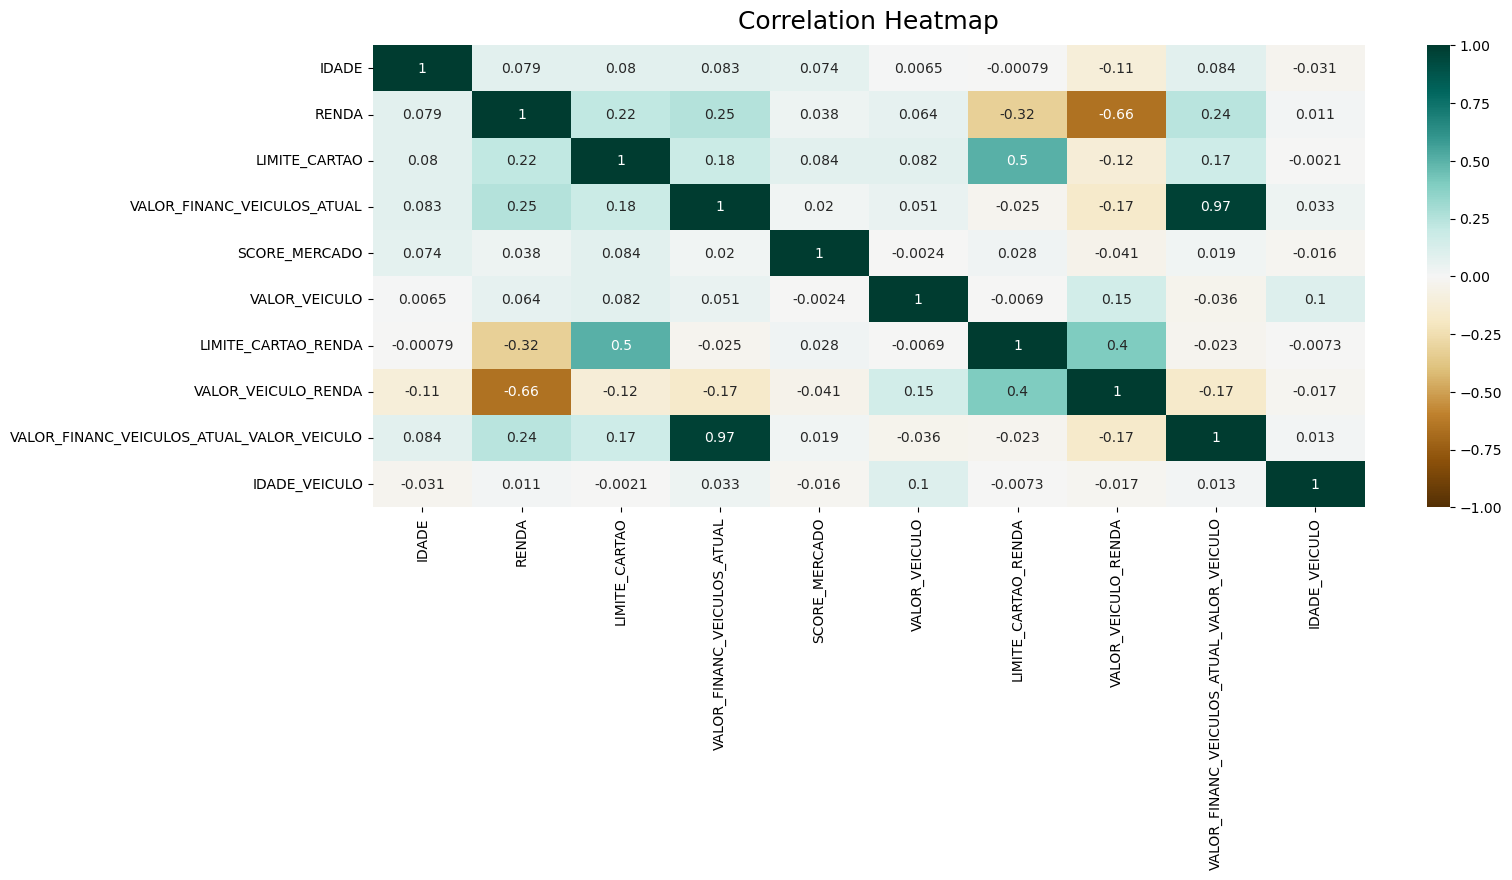

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_dev[var_quant].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

Análise: As variáveis fornecidas no dataset possuem pouca correlação entre elas, o que siginifica que existe "variedade de informação" para o modelo. Duas das variáveis criadas geraram alta correlação com outras duas já existentes, uma delas deve sair do modelo para evitar que o mesmo seja enviesado.

Verificar distribuição das variáveis e outiliers

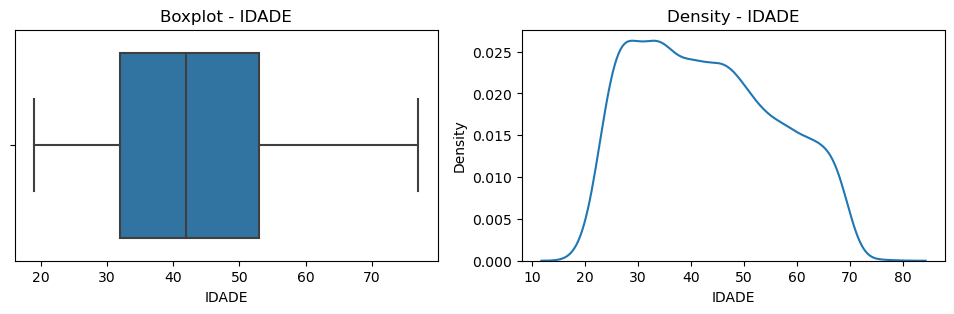

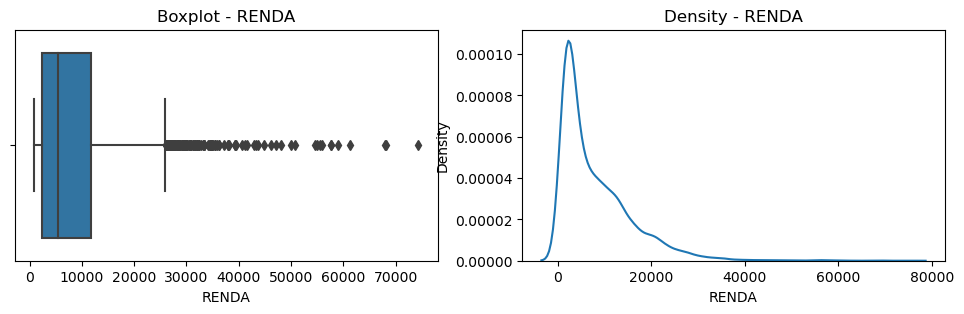

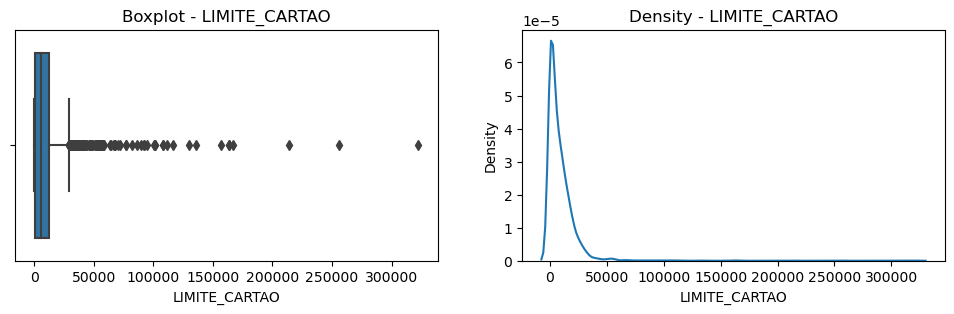

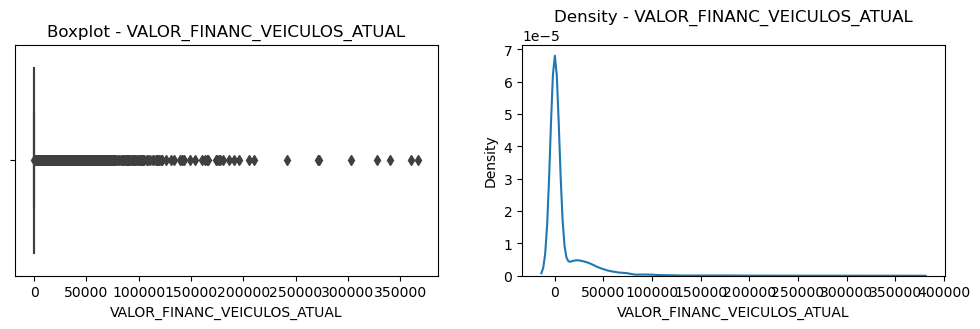

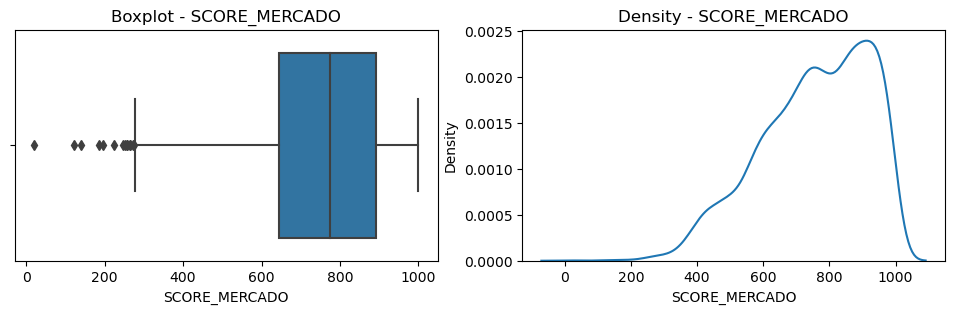

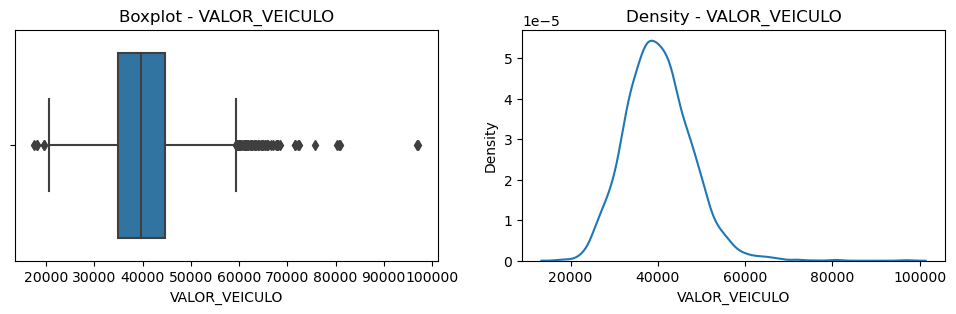

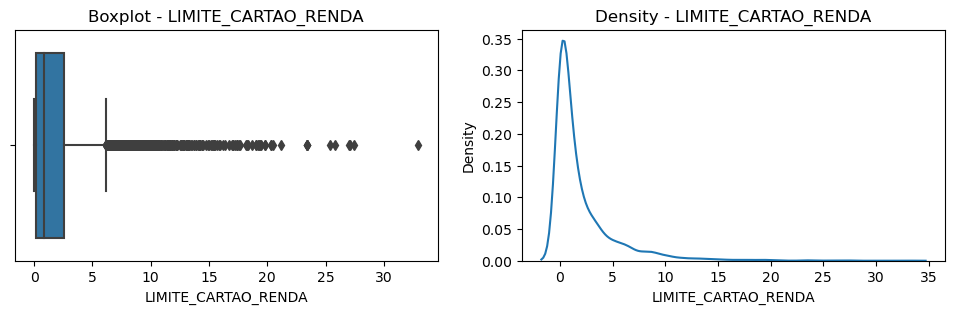

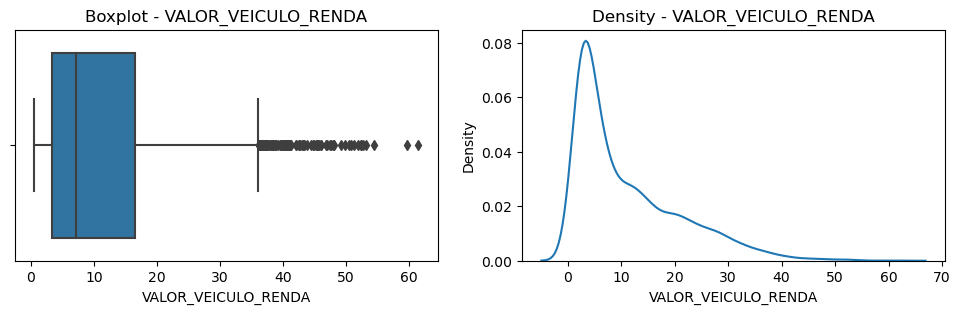

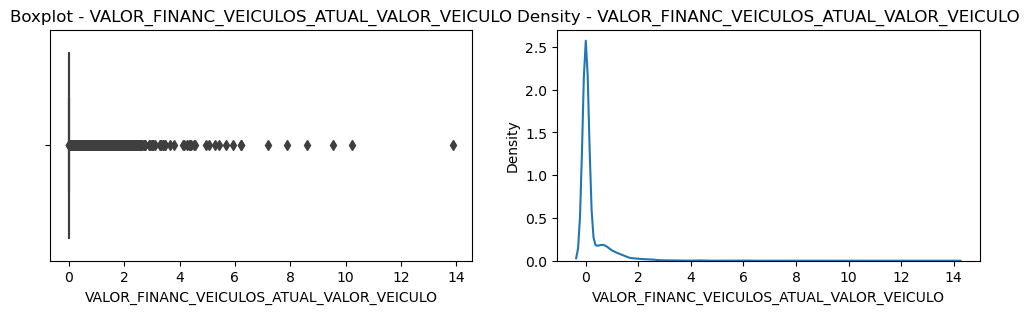

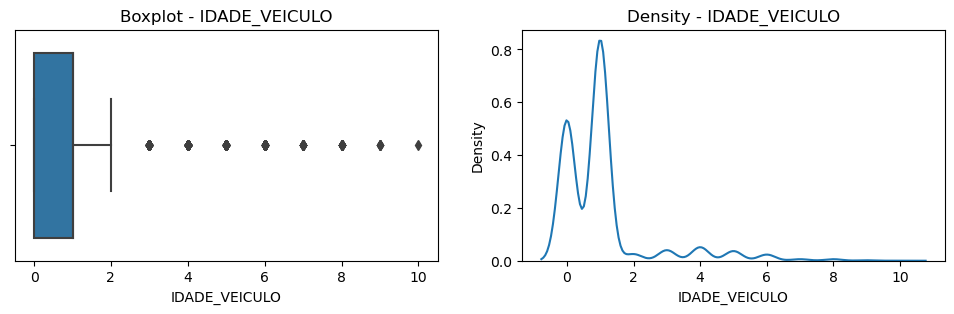

In [ ]:
for var in var_quant:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
    sns.boxplot(data=df_dev, x=var, ax=ax[0]).set(title='Boxplot - '+var)
    sns.kdeplot(data=df_dev, x=var).set(title='Density - '+var)

Análise: Com o boxplot e gráfico de densidade podemos verificar a distribuição das variáveis e outliers, que de alguma forma deverão ser tratados seja por normalização/padronização da variável ou categorização da mesma.

Correlação entre variáveis numéricas e a variável resposta

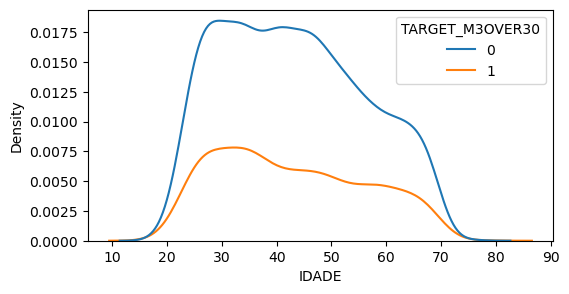

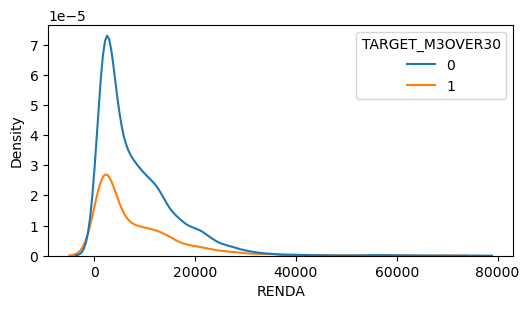

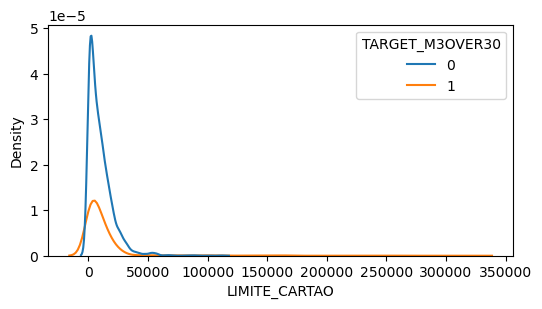

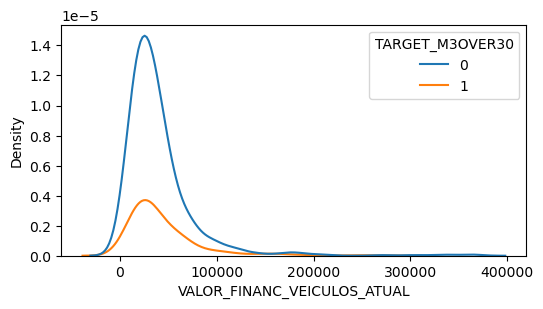

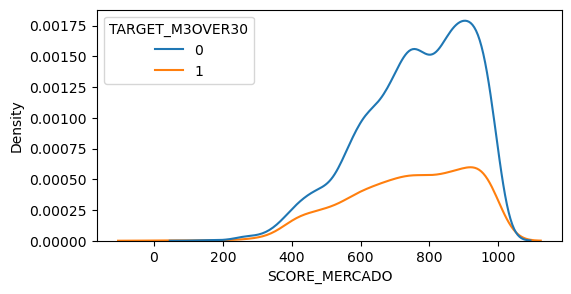

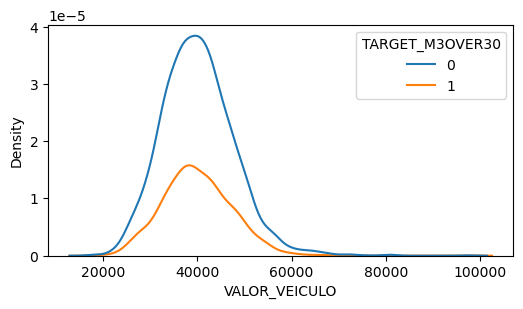

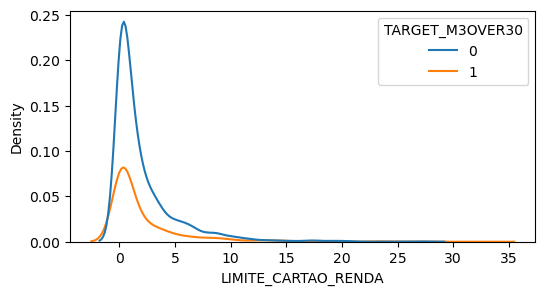

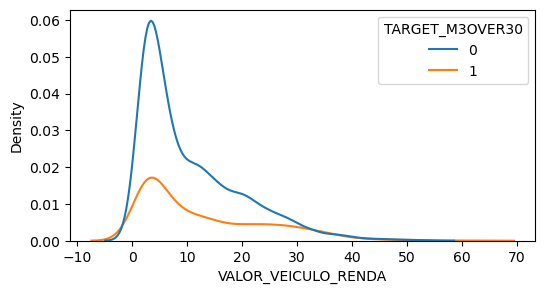

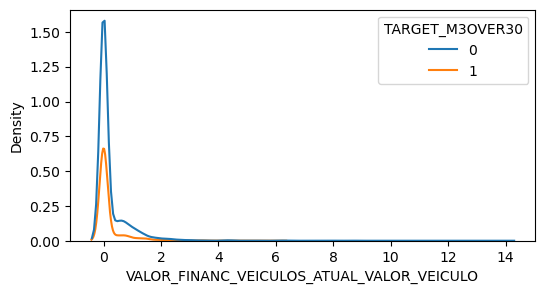

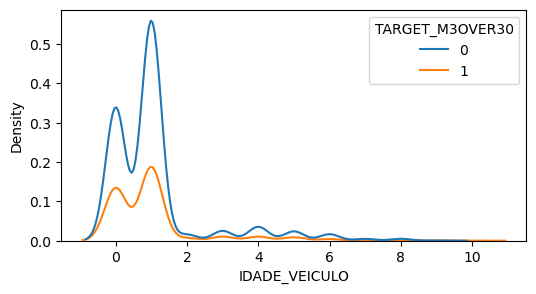

In [ ]:
for var in var_quant:
    if var=='VALOR_FINANC_VEICULOS_ATUAL':
        plt.figure(figsize=(6,3))
        sns.kdeplot(data=df_dev[df_dev['VALOR_FINANC_VEICULOS_ATUAL']>0], x='VALOR_FINANC_VEICULOS_ATUAL', hue="TARGET_M3OVER30")
    elif var=='LIMITE_CARTAO':
        plt.figure(figsize=(6,3))
        sns.kdeplot(data=df_dev[df_dev['LIMITE_CARTAO']>0], x='LIMITE_CARTAO', hue="TARGET_M3OVER30")
    else:
        plt.figure(figsize=(6,3))
        sns.kdeplot(data=df_dev, x=var, hue="TARGET_M3OVER30")

Particionamento em 10 grupos e inadimplência dos mesmos.

In [ ]:
df_group = pd.DataFrame()

In [ ]:
for var in var_quant:
    #print(np.quantile(df_dev[var], q=np.arange(0,1.1,0.1), duplicates='drop'))
    bin_ = np.quantile(df_dev[var], q=np.arange(0,1.1,0.1))
    bin_[0]=0
    df_group[var] = pd.cut(df_dev[var], bins=bin_,duplicates='drop', right = False,precision=0)

df_group['TARGET_M3OVER30']=df_dev['TARGET_M3OVER30']

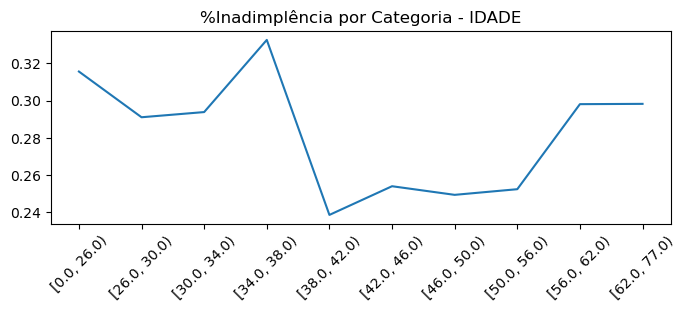

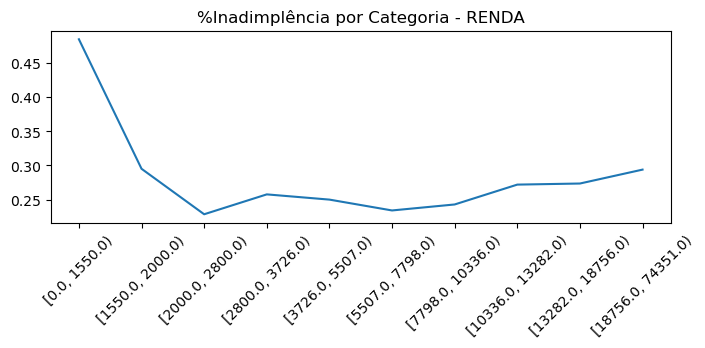

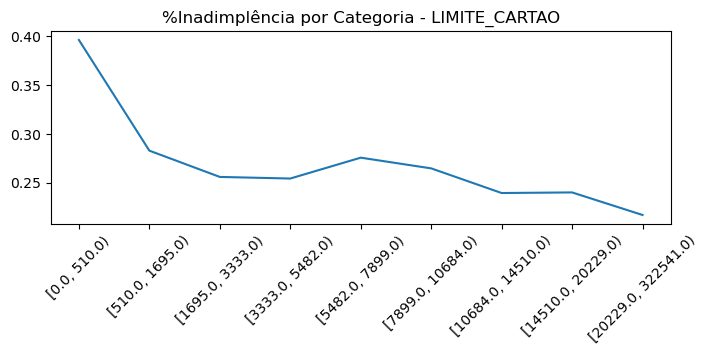

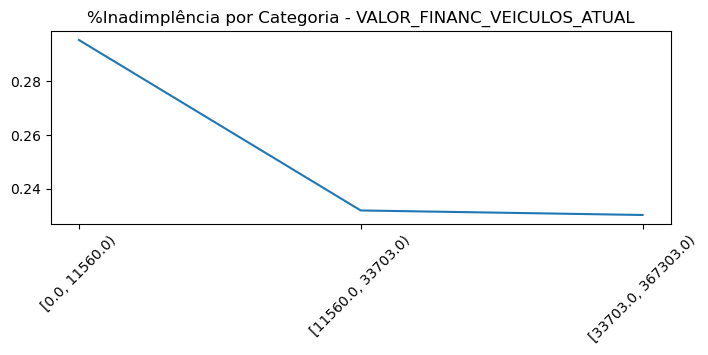

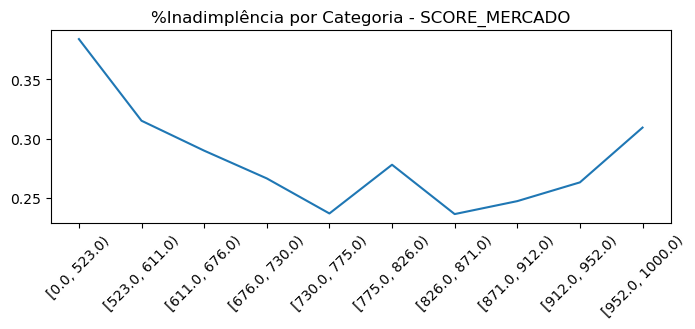

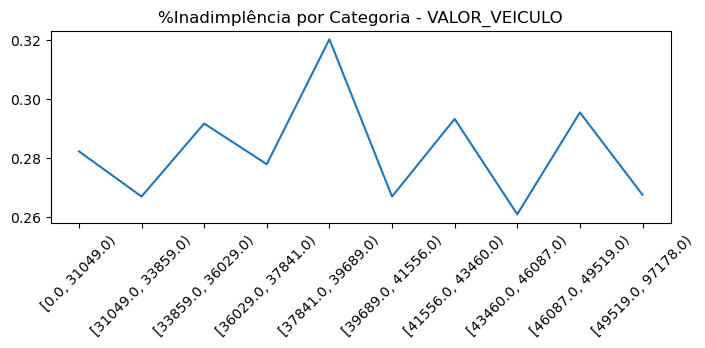

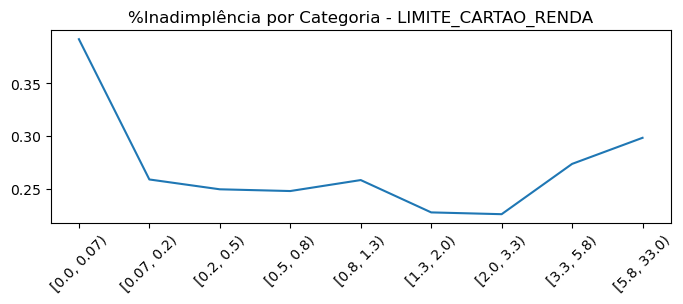

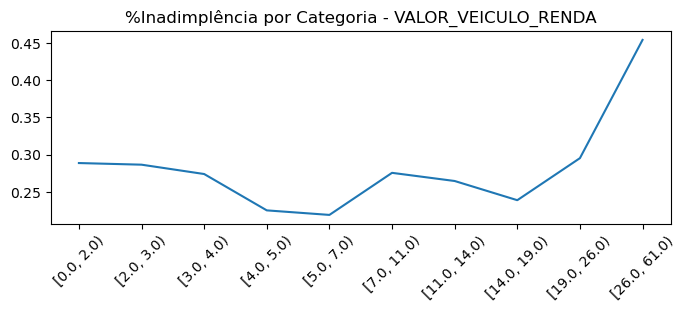

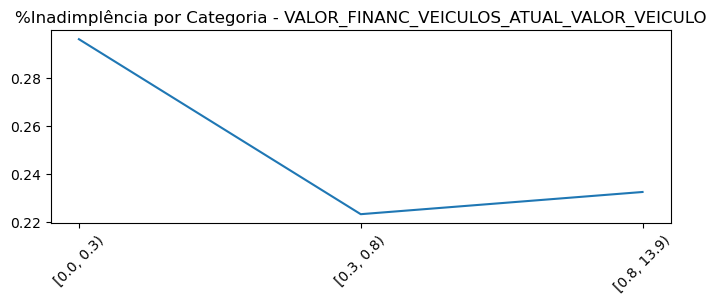

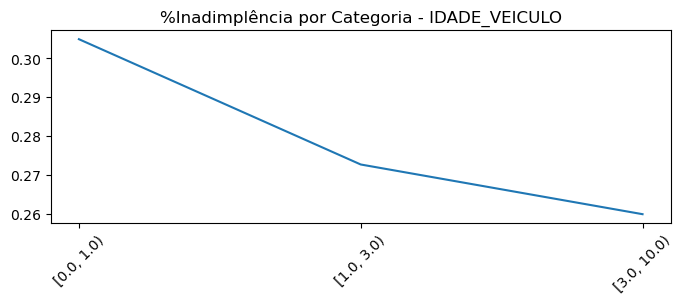

In [ ]:
for var in var_quant:
    plt.figure(figsize=(8,2.5))
    df_pivot = pd.pivot_table(df_group, index = [var], values='TARGET_M3OVER30', aggfunc='mean')
    intervals = [str(interval) for interval in df_pivot.index.categories]
    plt.plot(intervals,df_pivot['TARGET_M3OVER30'])
    plt.title('%Inadimplência por Categoria - '+var)
    plt.xticks(rotation=45)
    plt.show()


Análise: com os gráficos de Densidade por Resposta (bom=0, mau=1) e %Inadimplência por Categoria podemos verificar que não há uma linearidade entre variável preditora e variável resposta. Isto é, nos gráficos de densidade as curvas da populações Adimplente e Inadimplentes não estão visualmente separadas e os gráficos de inadimplência por categoria das variáveis preditoras não são lineares. Logo decidimos por categorizar as variáveis numéricas, assim poderemos separar grupos dentro da mesma variável com risco semelhante.

In [ ]:
#pd.pivot_table(df_group, index = ['VALOR_VEICULO_RENDA'], values='TARGET_M3OVER30', aggfunc='mean')

#### Variável Qualitativas

In [ ]:
pd.pivot_table(df_dev, index = 'ESTADO', aggfunc={'TARGET_M3OVER30': 'mean', 'CLIENTE':'count'})

,CLIENTE,TARGET_M3OVER30
ESTADO,,
CE,506,0.330040
MG,502,0.239044
PR,592,0.270270
RJ,681,0.340675
SC,475,0.263158
SP,1811,0.268360


Análise: Claramente temos 2 categorias de Estado em termos de inadimplência: Grupo1 composto CE e RJ e Grupo2 composto por MG, PR, SC, SP

### Categorização das Variáveis

#### Variáveis Quantitativas

**Observação:** O propósito de criar categorias é encontrar grupos semelhantes em termos de inadimplência para cada variável. Para isso, utilizaremos um combinação de técnicas: Particionamento em 10 grupos iguais, conforme mostrado acima, e grupamento baseado em Weight of Evidence através do pacote scorecardpy. Assim, será possível otimizar cada uma das ténicas.

In [ ]:
#Criando Dicionário de bins para aplicar

BINS = {'IDADE': np.array([0,34,38, 56, np.inf]),
        'RENDA': np.array([0,1550,2000, 10336, np.inf]),
        #'LIMITE_CARTAO': np.array([0, 510,7899, np.inf]),
        'LIMITE_CARTAO': np.array([0, 100,2000, 13000, np.inf]),
        'VALOR_FINANC_VEICULOS_ATUAL': np.array([0,11560,np.inf]),
        #'VALOR_FINANC_VEICULOS_ATUAL': np.array([0,2000, 32000, 50000,np.inf]),
        #'SCORE_MERCADO': np.array([0, 523 1000]),
        'SCORE_MERCADO': np.array([0, 520, 580, 720, 940, 1000]),
        'VALOR_VEICULO': np.array([0, 34941, 39689, np.inf]),
        'LIMITE_CARTAO_RENDA': np.array([0, 0.07, 3.3, np.inf]),
        'VALOR_VEICULO_RENDA': np.array([0, 4, 7, 26, np.inf]),
        'VALOR_FINANC_VEICULOS_ATUAL_VALOR_VEICULO': np.array([0, 0.3, np.inf]),
        'IDADE_VEICULO': np.array([0,1,4,np.inf])}

In [ ]:
valores = [pd.cut(df_dev[chave],bins = valor, right=False) for chave,valor in BINS.items()]
for col in range(0,len(var_quant)):
    df_dev[var_quant[col]+'_bin'] = valores[col].astype('str')

In [ ]:
#pd.pivot_table(df_group, index = ['SCORE_MERCADO'], values='TARGET_M3OVER30', aggfunc='mean')

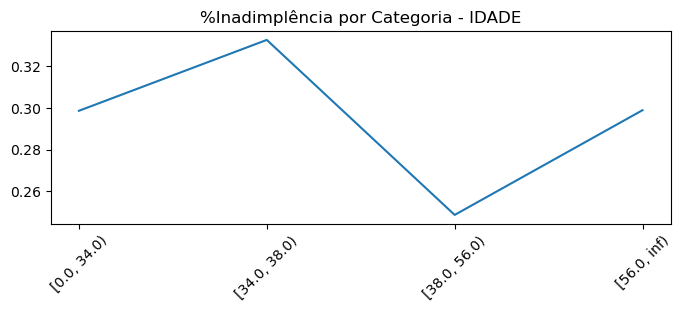

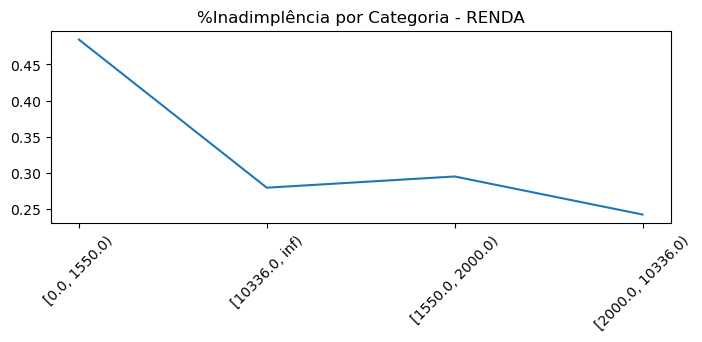

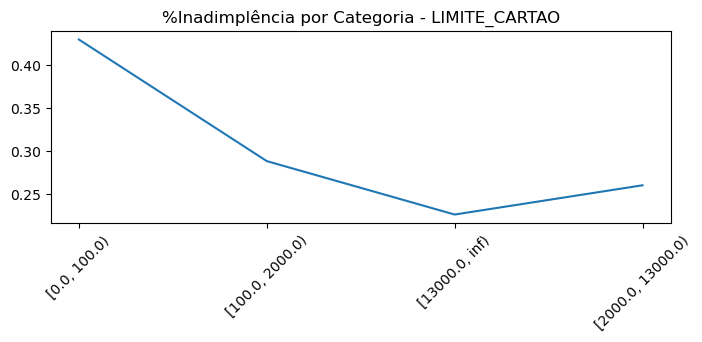

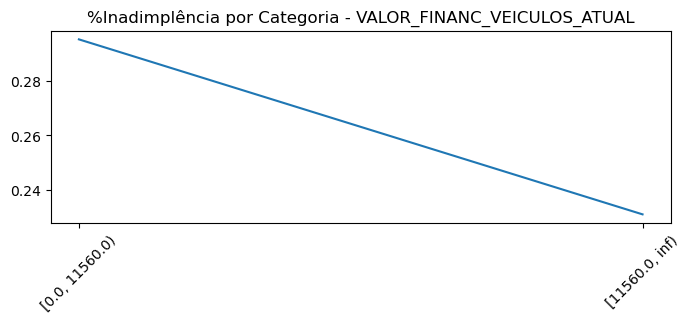

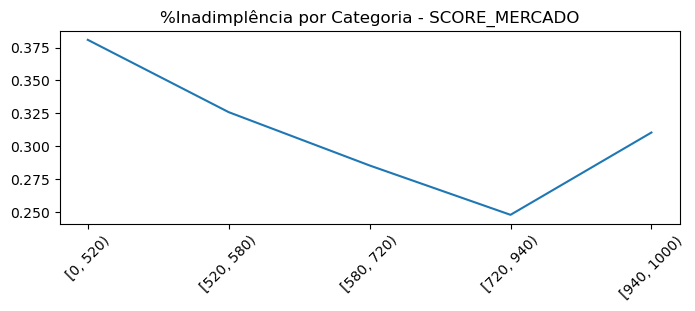

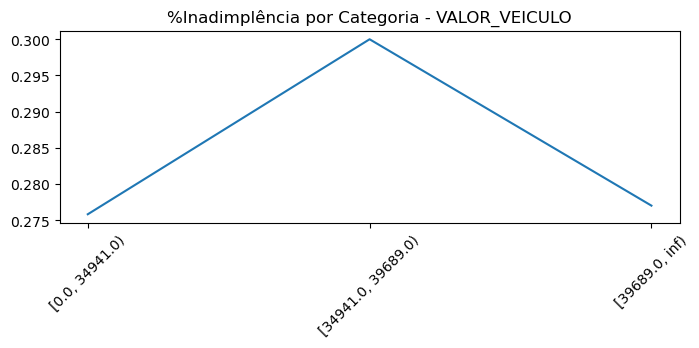

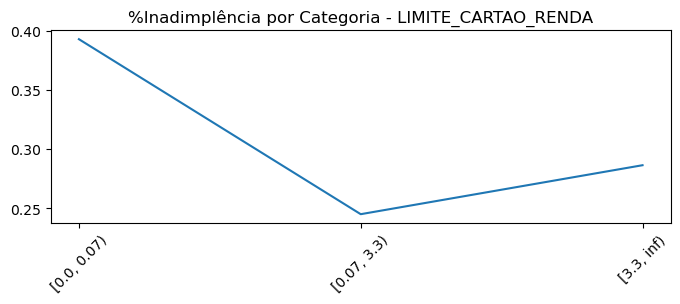

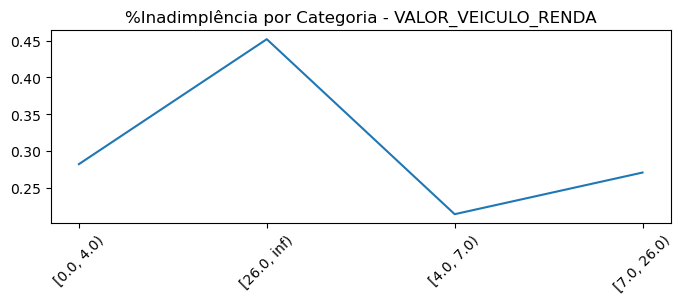

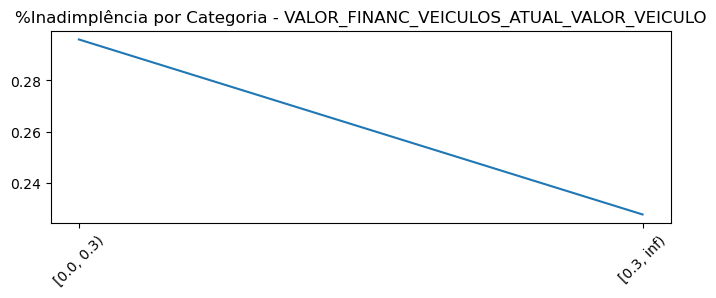

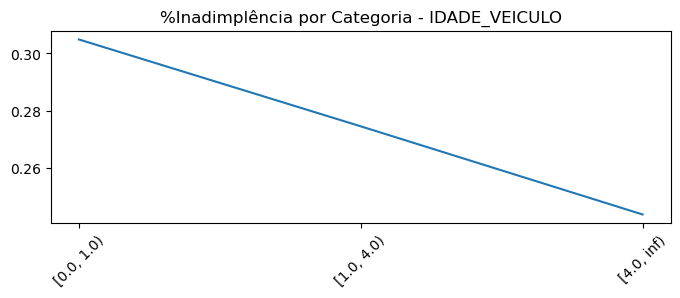

In [ ]:
for var in var_quant:
    plt.figure(figsize=(8,2.5))
    df_pivot = pd.pivot_table(df_dev, index = [var+'_bin'], values='TARGET_M3OVER30', aggfunc='mean')
    plt.plot(df_pivot.index,df_pivot['TARGET_M3OVER30'])
    plt.title('%Inadimplência por Categoria - '+var)
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
#df_dev['RENDA_bin'].value_counts()
#pd.pivot_table(df_dev, index = ['VALOR_VEICULO_RENDA'+'_bin'], values='TARGET_M3OVER30', aggfunc='mean')
#pd.pivot_table(df_dev, index = 'IDADE'+'_bin', aggfunc={'TARGET_M3OVER30': 'mean', 'CLIENTE':'count'})

In [ ]:
#Agrupamento de classes que não são sequenciais, mas que possuem taxas de inadimplência semelhantes

df_dev['IDADE_bin'] = np.where(df_dev['IDADE_bin'].isin(['[0.0, 34.0)', '[56.0, inf)']), '[0.0, 34.0),[56.0, inf)',df_dev['IDADE_bin'])
df_dev['RENDA_bin'] = np.where(df_dev['RENDA_bin'].isin(['[1550.0, 2000.0)', '[10336.0, inf)']), '[1550.0, 2000.0),[10336.0, inf)',df_dev['RENDA_bin'])
df_dev['VALOR_VEICULO_bin'] = np.where(df_dev['VALOR_VEICULO_bin'].isin(['[0.0, 34941.0)', '[39689.0, inf)']), '[0.0, 34941.0), [39689.0, inf)',df_dev['VALOR_VEICULO_bin'])
df_dev['VALOR_VEICULO_RENDA_bin'] = np.where(df_dev['VALOR_VEICULO_RENDA_bin'].isin(['[0.0, 4.0)', '[7.0, 26.0)']), '[0.0, 4.0), [7.0, 26.0)',df_dev['VALOR_VEICULO_RENDA_bin'])

In [ ]:
# Importando o pacote scorecardpy
import scorecardpy as sc

In [ ]:
bins_df = sc.woebin(df_dev.loc[:,list(np.concatenate([var_quant,['TARGET_M3OVER30']]))], y="TARGET_M3OVER30", replace=True)

[INFO] creating woe binning ...
Binning on 4567 rows and 11 columns in 00:00:14


In [ ]:
bins_df['SCORE_MERCADO']

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,SCORE_MERCADO,"[-inf,520.0)",449,0.098314,278,171,0.380846,0.446329,0.021301,0.041015,520.0,False
1,SCORE_MERCADO,"[520.0,580.0)",270,0.059120,182,88,0.325926,0.205616,0.002607,0.041015,580.0,False
2,SCORE_MERCADO,"[580.0,720.0)",1030,0.225531,736,294,0.285437,0.014636,0.000048,0.041015,720.0,False
3,SCORE_MERCADO,"[720.0,940.0)",2206,0.483030,1659,547,0.247960,-0.177235,0.014573,0.041015,940.0,False
4,SCORE_MERCADO,"[940.0,inf)",612,0.134005,422,190,0.310458,0.134305,0.002486,0.041015,inf,False


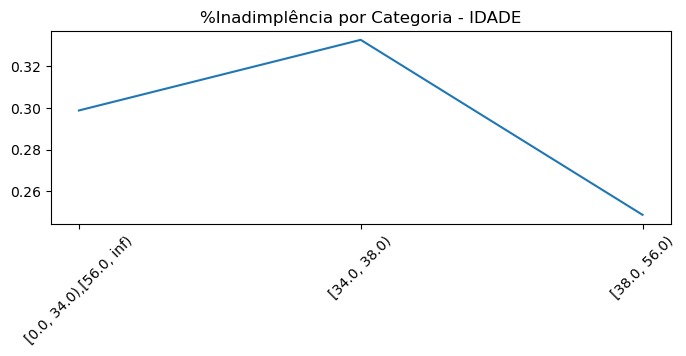

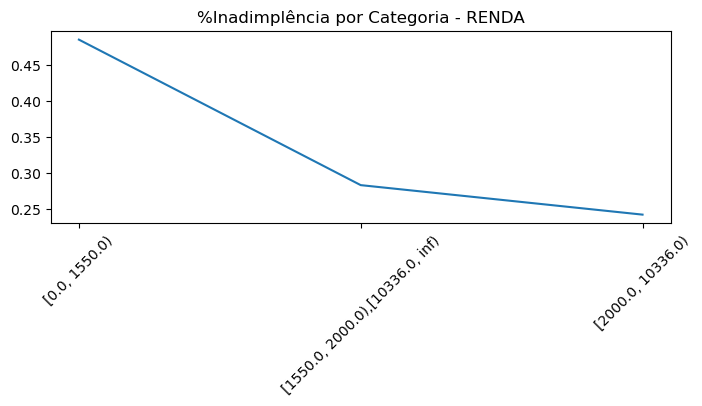

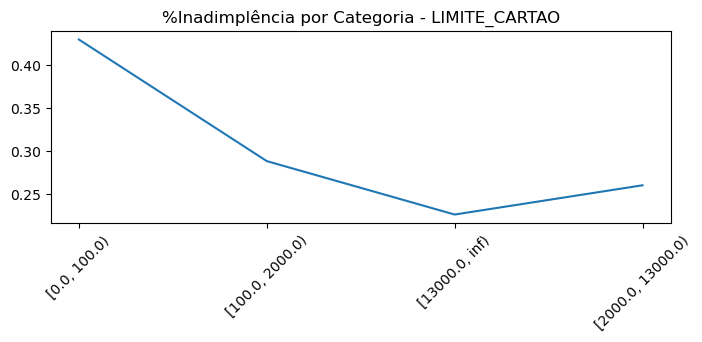

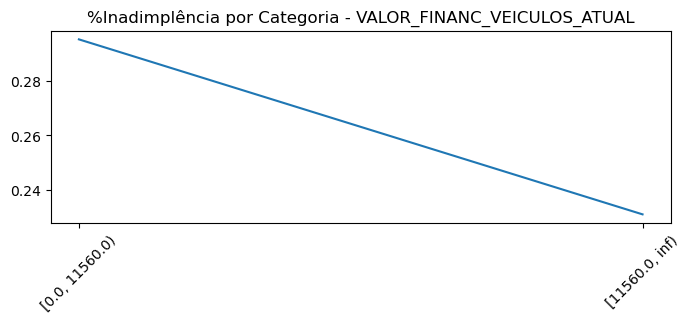

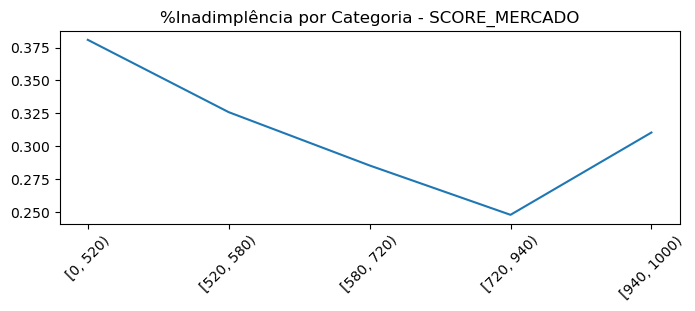

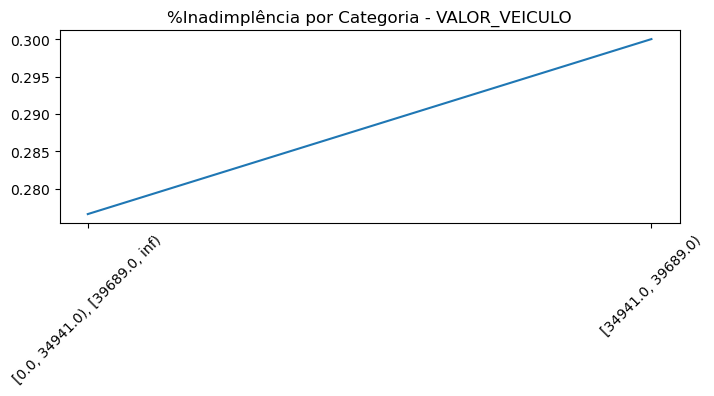

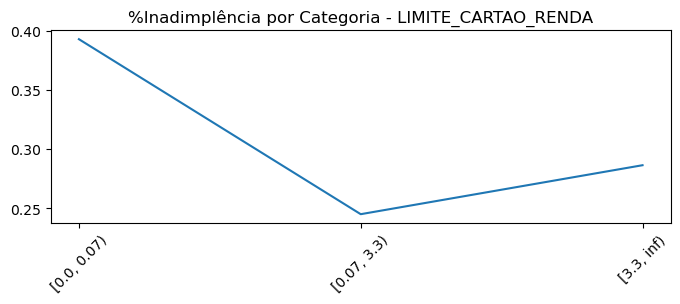

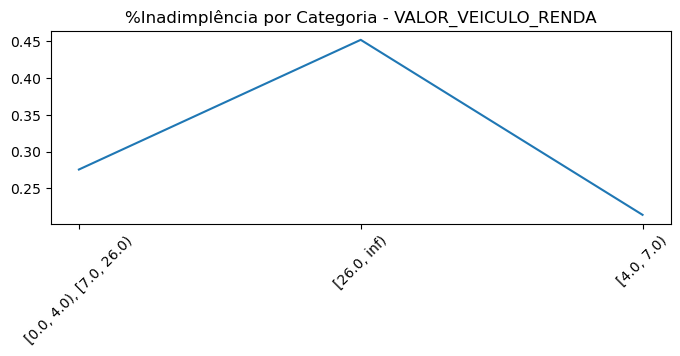

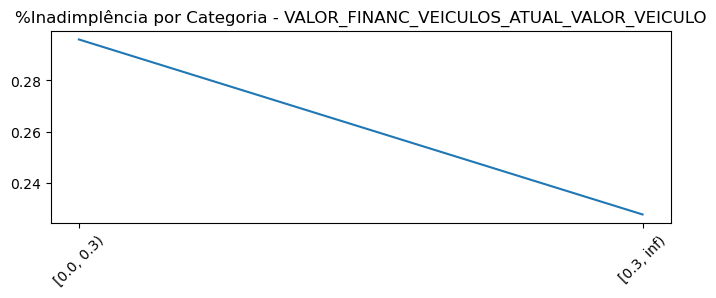

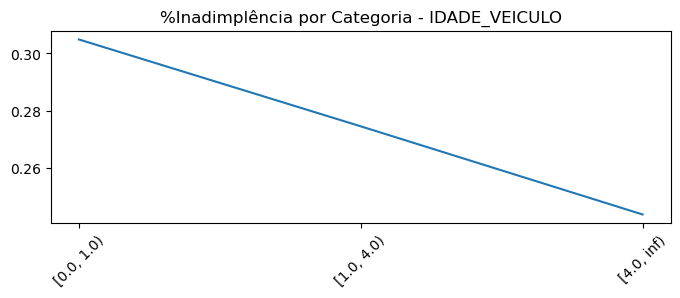

In [ ]:
for var in var_quant:
    plt.figure(figsize=(8,2.5))
    df_pivot = pd.pivot_table(df_dev, index = [var+'_bin'], values='TARGET_M3OVER30', aggfunc='mean')
    plt.plot(df_pivot.index,df_pivot['TARGET_M3OVER30'])
    plt.title('%Inadimplência por Categoria - '+var)
    plt.xticks(rotation=45)
    plt.show()

#### Variável Qualitativa

In [ ]:
df_dev['ESTADO_bin'] = np.where(df_dev['ESTADO'].isin(['CE', 'RJ']), 'CE,RJ', 'MG,PR,SC,SP')

In [ ]:
df_dev[df_dev.columns[pd.Series(df_dev.columns).str.endswith('bin')]].reset_index(drop=True).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4567 entries, 0 to 4566
Data columns (total 11 columns):
 #   Column                                         Non-Null Count  Dtype 
---  ------                                         --------------  ----- 
 0   IDADE_bin                                      4567 non-null   object
 1   RENDA_bin                                      4567 non-null   object
 2   LIMITE_CARTAO_bin                              4567 non-null   object
 3   VALOR_FINANC_VEICULOS_ATUAL_bin                4567 non-null   object
 4   SCORE_MERCADO_bin                              4567 non-null   object
 5   VALOR_VEICULO_bin                              4567 non-null   object
 6   LIMITE_CARTAO_RENDA_bin                        4567 non-null   object
 7   VALOR_VEICULO_RENDA_bin                        4567 non-null   object
 8   VALOR_FINANC_VEICULOS_ATUAL_VALOR_VEICULO_bin  4567 non-null   object
 9   IDADE_VEICULO_bin                              4567 non-null   

### Preparação da Base de Validação

In [ ]:
# Criação das mesmas variáveis na base de validação
df_val['LIMITE_CARTAO_RENDA'] = df_val['LIMITE_CARTAO']/df_val['RENDA']
df_val['VALOR_VEICULO_RENDA'] = df_val['VALOR_VEICULO']/df_val['RENDA']
df_val['VALOR_FINANC_VEICULOS_ATUAL_VALOR_VEICULO'] = df_val['VALOR_FINANC_VEICULOS_ATUAL']/df_val['VALOR_VEICULO']
df_val['IDADE_VEICULO'] = df_val['DATA_FINANCIAMENTO'].str.strip().str.split('-').str[0].astype(int)-df_val['ANO_VEICULO']

In [ ]:
# Aqui estamos aplicando os mesmos cortes encontrados no bloco acima e armazenados no dicionário BINS.
valores = [pd.cut(df_val[chave],bins = valor, right=False) for chave,valor in BINS.items()]
for col in range(0,len(var_quant)):
    df_val[var_quant[col]+'_bin'] = valores[col].astype('str')

In [ ]:
# Agrupamento da variável categórica
df_val['ESTADO_bin'] = np.where(df_val['ESTADO'].isin(['CE', 'RJ']), 'CE,RJ', 'MG,PR,SC,SP')

In [ ]:
# Agrupamento das classes não sequenciais, conforme feito na base de desenvolvimento
df_val['IDADE_bin'] = np.where(df_val['IDADE_bin'].isin(['[0.0, 34.0)', '[56.0, inf)']), '[0.0, 34.0),[56.0, inf)',df_val['IDADE_bin'])
df_val['RENDA_bin'] = np.where(df_val['RENDA_bin'].isin(['[1550.0, 2000.0)', '[10336.0, inf)']), '[1550.0, 2000.0),[10336.0, inf)',df_val['RENDA_bin'])
df_val['VALOR_VEICULO_bin'] = np.where(df_val['VALOR_VEICULO_bin'].isin(['[0.0, 34941.0)', '[39689.0, inf)']), '[0.0, 34941.0), [39689.0, inf)',df_val['VALOR_VEICULO_bin'])
df_val['VALOR_VEICULO_RENDA_bin'] = np.where(df_val['VALOR_VEICULO_RENDA_bin'].isin(['[0.0, 4.0)', '[7.0, 26.0)']), '[0.0, 4.0), [7.0, 26.0)',df_val['VALOR_VEICULO_RENDA_bin'])

### Modelo

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from lightgbm import LGBMClassifier
from scipy.stats import ks_2samp

In [ ]:
#Variáveis Preditoras
# As variáveis 'VALOR_VEICULO_RENDA_bin' e 'VALOR_FINANC_VEICULOS_ATUAL_VALOR_VEICULO_bin' geraram correlação com as
# variáveis 'RENDA' e 'VALOR_FINANC_VEICULOS_ATUAL'. Como esse par de variáveis criadas possuem IV menor vamos
# apenas desconsiderá-las.

variaveis_x = ['IDADE_bin',
               'RENDA_bin',
               'LIMITE_CARTAO_bin',
               'VALOR_FINANC_VEICULOS_ATUAL_bin',
               'SCORE_MERCADO_bin',
               'VALOR_VEICULO_bin',
               'LIMITE_CARTAO_RENDA_bin',
               #'VALOR_VEICULO_RENDA_bin',
               #'VALOR_FINANC_VEICULOS_ATUAL_VALOR_VEICULO_bin',
               'IDADE_VEICULO_bin',
               'ESTADO_bin']

X = df_dev[variaveis_x]
Y = 1-df_dev['TARGET_M3OVER30']

# Cria objeto encoder
encoder_fit = OrdinalEncoder().fit(X.values)

# Aplica encoder na base de treino
X_encoder = encoder_fit.transform(X.values)


X_val = df_val[variaveis_x]
Y_val = 1 - df_val['TARGET_M3OVER30']

# Aplica encoder na base de validação
X_encoder_val = encoder_fit.transform(X_val.values)

#### Calcula o melhor threshold e as métricas de performance do modelo

In [ ]:
def threshold(y_test,X_test, y_pred_proba):
    thresholds = list(np.arange(0.4, 0.6, 0.02))
    scores = []
    for threshold in thresholds:
        y_pred_threshold = (y_pred_proba >= threshold).astype(int)
        scores.append(metrics.accuracy_score(y_test, y_pred_threshold))

    # Find the threshold with the highest Accuracy
    best_threshold = thresholds[scores.index(max(scores))]
    #print("Best threshold: ", best_threshold)

    return best_threshold

In [ ]:
def Performance(y_test,X_test, y_pred_proba, best_threshold):

    y_pred_threshold = (y_pred_proba >= best_threshold).astype(int)
    #print(metrics.accuracy_score(y_test, y_pred_threshold))

    # Calculate the accuracy
    accuracy = round(metrics.accuracy_score(y_test, y_pred_threshold),4)

    # Precisao
    precision = round(metrics.precision_score(y_test, y_pred_threshold),4)

    # Recall
    recall = round(metrics.recall_score(y_test, y_pred_threshold),4)

    # f1 score
    # f1 = metrics.f1_score(y_test, y_pred_threshold)

    # AUC
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = round(metrics.roc_auc_score(y_test, y_pred_proba),3)

    return accuracy, precision, recall, auc

In [ ]:
#from mlxtend.feature_selection import SequentialFeatureSelector

#### Logistic Regression

In [ ]:
lr = LogisticRegression(random_state=42)

lr.fit(X_encoder, Y)

LogisticRegression(random_state=42)

In [ ]:
df_dev['predict_proba'] = lr.predict_proba(X_encoder)[:, 1]
df_val['predict_proba'] = lr.predict_proba(X_encoder_val)[:, 1]

In [ ]:
best_threshold = threshold(Y,
                           X_encoder,
                           y_pred_proba = df_dev['predict_proba'])
best_threshold

0.5600000000000002

In [ ]:
accuracy, precision, recall, auc = Performance(Y_val, X_encoder_val, df_val['predict_proba'], best_threshold)
BLR = {'Base': 'Base Validação',
      'Accuracy': accuracy,
      'precision': precision,
      'recall': recall,
       'AUC': auc}
BLR

{'Base': 'Base Validação',
 'Accuracy': 0.7156,
 'precision': 0.7307,
 'recall': 0.9538,
 'AUC': 0.602}

In [ ]:
Probabilidade = df_val['predict_proba']
prob = pd.DataFrame({'Bom_Mau': Y_val, 'Probabilidade': Probabilidade})
ks_2samp(prob.loc[(prob["Bom_Mau"]==1),'Probabilidade'], prob.loc[(prob["Bom_Mau"]==0),'Probabilidade'])

KstestResult(statistic=0.16460382622270728, pvalue=1.0425665432144773e-11, statistic_location=0.7008043632063617, statistic_sign=-1)

#### LGBMClassifier

In [ ]:
#lgbm = LGBMClassifier(random_state=42)
#
## Grid de hiperparâmetros
#param_grid = {
#    'n_estimators': [160, 180, 200, 220],
#    'max_depth': [5,6,7,9],
#    'learning_rate': [0.01, 0.1, 0.06],
#    'num_leaves': [10,12,14,16]
#}
#
#grid_search = GridSearchCV(lgbm, param_grid, cv=5, n_jobs=-1)
#grid_search.fit(X_encoder, Y)
#
#lgbm = LGBMClassifier(random_state=42).set_params(**grid_search.best_params_)
#lgbm.fit(X_encoder, Y)

In [ ]:
lgbm = LGBMClassifier(learning_rate=0.01, max_depth=6, n_estimators=160, num_leaves=12, random_state=42)
lgbm.fit(X_encoder, Y)

[LightGBM] [Info] Number of positive: 3277, number of negative: 1290
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27
[LightGBM] [Info] Number of data points in the train set: 4567, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.717539 -> initscore=0.932286
[LightGBM] [Info] Start training from score 0.932286


LGBMClassifier(learning_rate=0.01, max_depth=6, n_estimators=160, num_leaves=12,
               random_state=42)

In [ ]:
df_dev['predict_proba'] = lgbm.predict_proba(X_encoder)[:, 1]
df_val['predict_proba'] = lgbm.predict_proba(X_encoder_val)[:, 1]

best_threshold = threshold(Y,
                           X_encoder,
                           y_pred_proba = df_dev['predict_proba'])

accuracy, precision, recall, auc = Performance(Y_val, X_encoder_val, df_val['predict_proba'], best_threshold)
BLG = {'Base': 'Base Validação',
      'Accuracy': accuracy,
      'precision': precision,
      'recall': recall,
       'AUC': auc}
BLG

{'Base': 'Base Validação',
 'Accuracy': 0.7147,
 'precision': 0.7277,
 'recall': 0.9604,
 'AUC': 0.617}

In [ ]:
Probabilidade = df_val['predict_proba']
prob = pd.DataFrame({'Bom_Mau': Y_val, 'Probabilidade': Probabilidade})
ks_2samp(prob.loc[(prob["Bom_Mau"]==1),'Probabilidade'], prob.loc[(prob["Bom_Mau"]==0),'Probabilidade'])

KstestResult(statistic=0.19997145149283396, pvalue=4.218086050439989e-17, statistic_location=0.7159316697447045, statistic_sign=-1)

<Axes: >

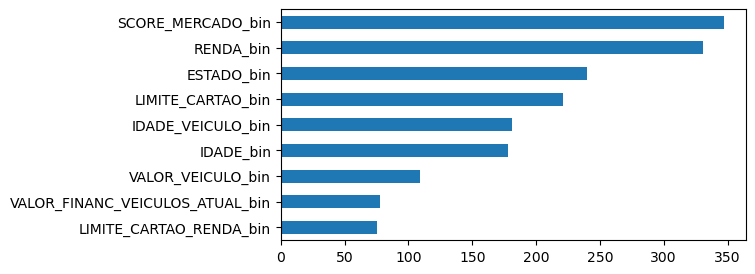

In [ ]:
lgbm_importances = pd.Series(lgbm.feature_importances_, index=X.columns ).sort_values(ascending = True)
plt.figure(figsize=(6,3))
lgbm_importances.plot(kind = 'barh')

#### GradientBoosting

In [ ]:
#gbc = GradientBoostingClassifier(random_state=42)
#
## Grid de hiperparâmetros
#param_grid = {
#    'n_estimators': [160, 180, 200],
#    'max_depth': [5,6,7,9],
#    'learning_rate': [0.01, 0.1, 0.06],
#    'min_samples_split': [2,3,4],
#    'min_samples_leaf': [1,2,3]
#}
#
#grid_search = GridSearchCV(gbc, param_grid, cv=5, n_jobs=-1)
#grid_search.fit(X_encoder, Y)
#
#gbc = GradientBoostingClassifier(random_state=42).set_params(**grid_search.best_params_)
#gbc.fit(X_encoder, Y)

In [ ]:
gbc = GradientBoostingClassifier(learning_rate=0.01, max_depth=5, min_samples_leaf=2,n_estimators=160, random_state=42)
gbc.fit(X_encoder, Y)

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, min_samples_leaf=2,
                           n_estimators=160, random_state=42)

In [ ]:
df_dev['predict_proba'] = gbc.predict_proba(X_encoder)[:, 1]
df_val['predict_proba'] = gbc.predict_proba(X_encoder_val)[:, 1]

best_threshold = threshold(Y,
                           X_encoder,
                           y_pred_proba = df_dev['predict_proba'])

accuracy, precision, recall, auc = Performance(Y_val, X_encoder_val, df_val['predict_proba'], best_threshold)
BGBC = {'Base': 'Base Validação',
      'Accuracy': accuracy,
      'precision': precision,
      'recall': recall,
       'AUC': auc}
BGBC

{'Base': 'Base Validação',
 'Accuracy': 0.7181,
 'precision': 0.7308,
 'recall': 0.9592,
 'AUC': 0.613}

In [ ]:
Probabilidade = df_val['predict_proba']
prob = pd.DataFrame({'Bom_Mau': Y_val, 'Probabilidade': Probabilidade})
ks_2samp(prob.loc[(prob["Bom_Mau"]==1),'Probabilidade'], prob.loc[(prob["Bom_Mau"]==0),'Probabilidade'])

KstestResult(statistic=0.1964959417755003, pvalue=1.5956103146952092e-16, statistic_location=0.7390629109737805, statistic_sign=-1)

<Axes: >

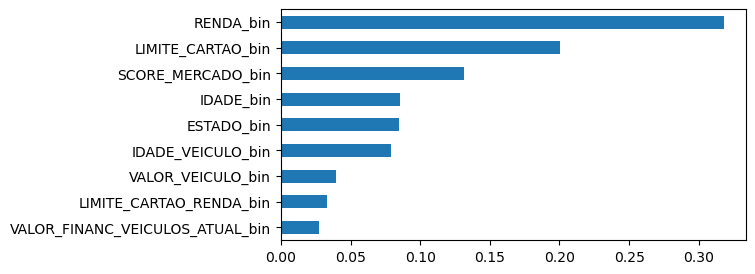

In [ ]:
gbc_importances = pd.Series(gbc.feature_importances_, index=X.columns ).sort_values(ascending = True)
plt.figure(figsize=(6,3))
gbc_importances.plot(kind = 'barh')

#### Random Forest

In [ ]:
#rfc = RandomForestClassifier(random_state=42)
#
## Grid de hiperparâmetros
#param_grid = {
#    'n_estimators': [160, 180, 200, 220],
#    'max_depth': [5,6,7,9],
#    'bootstrap': [True, False],
#    'min_samples_split': [2,5,10],
#    'min_samples_leaf': [1,2,4]
#}
#
#grid_search = GridSearchCV(rfc, param_grid, cv=5, n_jobs=-1)
#grid_search.fit(X_encoder, Y)
#
#rfc = RandomForestClassifier(random_state=42).set_params(**grid_search.best_params_)
#rfc.fit(X_encoder, Y)

In [ ]:
rfc = RandomForestClassifier(bootstrap=False, max_depth=6, min_samples_split=10, n_estimators=200, random_state=42)
rfc.fit(X_encoder, Y)

RandomForestClassifier(bootstrap=False, max_depth=6, min_samples_split=10,
                       n_estimators=200, random_state=42)

In [ ]:
df_dev['predict_proba'] = rfc.predict_proba(X_encoder)[:, 1]
df_val['predict_proba'] = rfc.predict_proba(X_encoder_val)[:, 1]

best_threshold = threshold(Y,
                           X_encoder,
                           y_pred_proba = df_dev['predict_proba'])

accuracy, precision, recall, auc = Performance(Y_val, X_encoder_val, df_val['predict_proba'], best_threshold)
BRFC = {'Base': 'Base Validação',
      'Accuracy': accuracy,
      'precision': precision,
      'recall': recall,
       'AUC': auc}
BRFC

{'Base': 'Base Validação',
 'Accuracy': 0.7156,
 'precision': 0.7271,
 'recall': 0.964,
 'AUC': 0.617}

In [ ]:
Probabilidade = df_val['predict_proba']
prob = pd.DataFrame({'Bom_Mau': Y_val, 'Probabilidade': Probabilidade})
ks_2samp(prob.loc[(prob["Bom_Mau"]==1),'Probabilidade'], prob.loc[(prob["Bom_Mau"]==0),'Probabilidade'])

KstestResult(statistic=0.20399353864166925, pvalue=8.793093109141328e-18, statistic_location=0.713004900886975, statistic_sign=-1)

<Axes: >

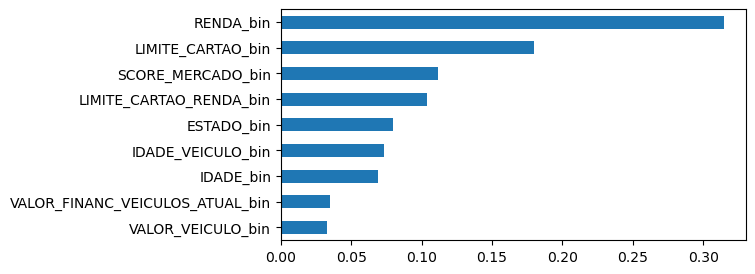

In [ ]:
rfc_importances = pd.Series(rfc.feature_importances_, index=X.columns ).sort_values(ascending = True)
plt.figure(figsize=(6,3))
rfc_importances.plot(kind = 'barh')

### Modelo Final

O critério utilizado para escolha no modelo final foi KS na base de validação. KS é uma das medidas estatítiscas mais aplicadas no mercado para avaliar o poder de discriminação entre 'bons' e 'maus'. Nesse sentido o Algoritmo RandomForest foi o que gerou maior KS.

In [ ]:
mlf = rfc

df_val['predict_proba'] = mlf.predict_proba(X_encoder_val)[:, 1]

best_threshold = threshold(Y,
                           X_encoder,
                           y_pred_proba = df_dev['predict_proba'])

### KS

#### KS - Modelo Final

In [ ]:
Probabilidade = df_val['predict_proba']
prob = pd.DataFrame({'Bom_Mau': Y_val, 'Probabilidade': Probabilidade})
ks_2samp(prob.loc[(prob["Bom_Mau"]==1),'Probabilidade'], prob.loc[(prob["Bom_Mau"]==0),'Probabilidade'])

KstestResult(statistic=0.20399353864166925, pvalue=8.793093109141328e-18, statistic_location=0.713004900886975, statistic_sign=-1)

O melhor modelo resultou em um KS de 20,4%

#### KS - Modelo de Mercado

In [ ]:
Probabilidade = df_val['SCORE_MERCADO']
prob = pd.DataFrame({'Bom_Mau': Y_val, 'Probabilidade': Probabilidade})
ks_2samp(prob.loc[(prob["Bom_Mau"]==1),'Probabilidade'], prob.loc[(prob["Bom_Mau"]==0),'Probabilidade'])

KstestResult(statistic=0.08960165798165667, pvalue=0.000900539194332999, statistic_location=605.0000000000001, statistic_sign=-1)

KS do modelo atual utilizado, SCORE_MERCADO, possui um KS de 9%.
O modelo final possui um KS maior do que o modelo atual, isso significa que tem um poder de discriminação maior

### Estabilidade

#### Transformação de probabilidade em Score

In [ ]:
# A função abaixo é um proposta de gerar uma curva de score normal (forma de sino).
def score_calculado(vetor, cortes, score):
    if vetor<=cortes[1]:
        score_calculado = score[0] + (score[1]-score[0])*(vetor-cortes[0])/(cortes[1]-cortes[0])

    elif vetor<=cortes[2]:
        score_calculado = score[1] + (score[2]-score[1])*(vetor-cortes[1])/(cortes[2]-cortes[1])

    elif vetor<=cortes[3]:
        score_calculado = score[2] + (score[3]-score[2])*(vetor-cortes[2])/(cortes[3]-cortes[2])

    elif vetor<=cortes[4]:
        score_calculado = score[3] + (score[4]-score[3])*(vetor-cortes[3])/(cortes[4]-cortes[3])

    elif vetor<=cortes[5]:
        score_calculado = score[4] + (score[5]-score[4])*(vetor-cortes[4])/(cortes[5]-cortes[4])

    elif vetor<=cortes[6]:
        score_calculado = score[5] + (score[6]-score[5])*(vetor-cortes[5])/(cortes[6]-cortes[5])

    elif vetor<=cortes[7]:
        score_calculado = score[6] + (score[7]-score[6])*(vetor-cortes[6])/(cortes[7]-cortes[6])

    elif vetor<=cortes[8]:
        score_calculado = score[7] + (score[8]-score[7])*(vetor-cortes[7])/(cortes[8]-cortes[7])

    elif vetor<=cortes[9]:
        score_calculado = score[8] + (score[9]-score[8])*(vetor-cortes[8])/(cortes[9]-cortes[8])

    else:
        score_calculado = score[9] + (score[10]-score[9])*(vetor-cortes[9])/(cortes[10]-cortes[9])

    return score_calculado

In [ ]:
# Percentis para dar normalidade a curva de score
probs =np.quantile(df_dev['predict_proba'], q=np.array([0, 2.3, 6.7, 15.9, 30.9, 50, 69.1, 84.1, 93.3, 97.7, 100])/100)
score=np.array([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])

In [ ]:
# Transformação Probabilidade em Score
df_dev['Score']=df_dev['predict_proba'].apply(lambda x: score_calculado(x,probs, score))
df_val['Score']=df_val['predict_proba'].apply(lambda x: score_calculado(x,probs, score))

#### Distribuição Modelo Final

Cálculo dos decis pela base de desenvolvimento e aplicação na base de validação

In [ ]:
# Intervalos por Decil, será importante para avaliar a estabilidade do modelo
bin_=np.round(np.quantile(df_dev['Score'], q=np.arange(0,1.1,0.1))).astype(int)
bin_[10]=1000
bin_[0]=0

df_dev['Score_decil'] = pd.cut(df_dev['Score'], bins=bin_,duplicates='drop', right = False,precision=0)
df_val['Score_decil'] = pd.cut(df_val['Score'], bins=bin_,duplicates='drop', right = False,precision=0)

[Text(0.5, 1.0, 'Base de Validação')]

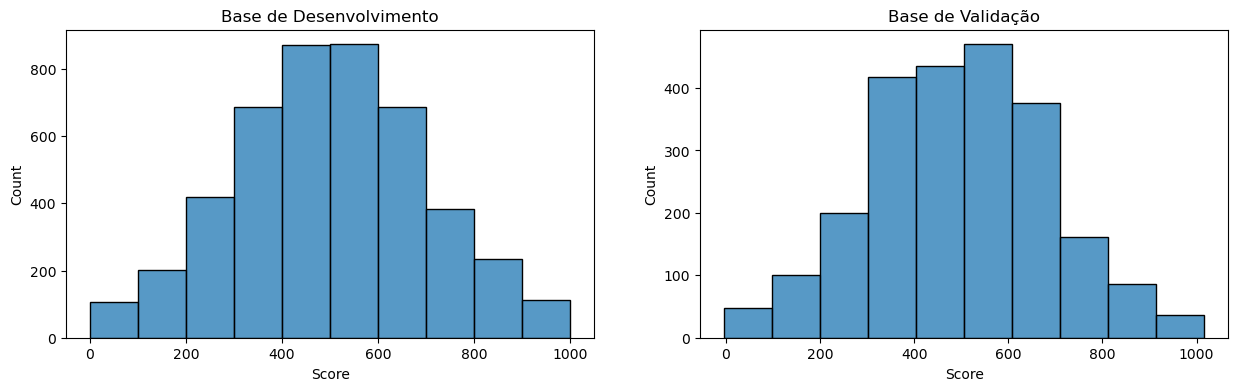

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
sns.histplot(data=df_dev, x="Score", bins=10,ax=ax[0]).set(title='Base de Desenvolvimento')
sns.histplot(data=df_val, x="Score", bins=10,ax=ax[1]).set(title='Base de Validação')

#### Distribuição Modelo Mercado

Cálculo das faixas de decis do SCORE_MERCADO

In [ ]:
# Intervalos por Decil, será importante para avaliar a estabilidade do modelo
bin_=np.round(np.quantile(df_dev['SCORE_MERCADO'], q=np.arange(0,1.1,0.1))).astype(int)
bin_[10]=1000
bin_[0]=0

df_dev['SCORE_MERCADO_decil'] = pd.cut(df_dev['SCORE_MERCADO'], bins=bin_,duplicates='drop', right = False,precision=0)
df_val['SCORE_MERCADO_decil'] = pd.cut(df_val['SCORE_MERCADO'], bins=bin_,duplicates='drop', right = False,precision=0)

[Text(0.5, 1.0, 'Base de Validação')]

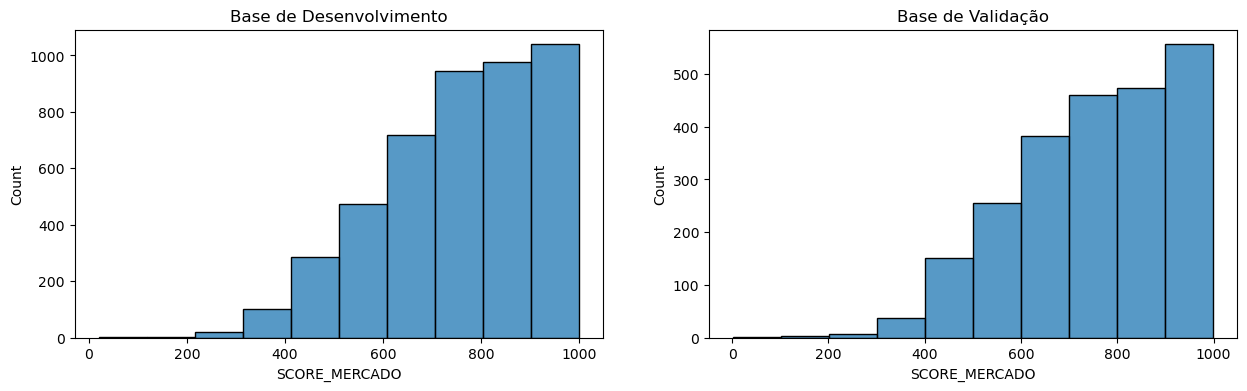

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
sns.histplot(data=df_dev, x="SCORE_MERCADO", bins=10,ax=ax[0]).set(title='Base de Desenvolvimento')
sns.histplot(data=df_val, x="SCORE_MERCADO", bins=10,ax=ax[1]).set(title='Base de Validação')

Análise: O modelo final ficou mais bem distribuido do que o modelo de mercado, este possui uma concentração em scores mais altos ficando difícil de discriminar 'bom' e 'mau'.

#### Distribuição por Decil - Modelo Final

[Text(0.5, 1.0, 'Modelo Final: Distribuição por Decil na Base de Validação')]

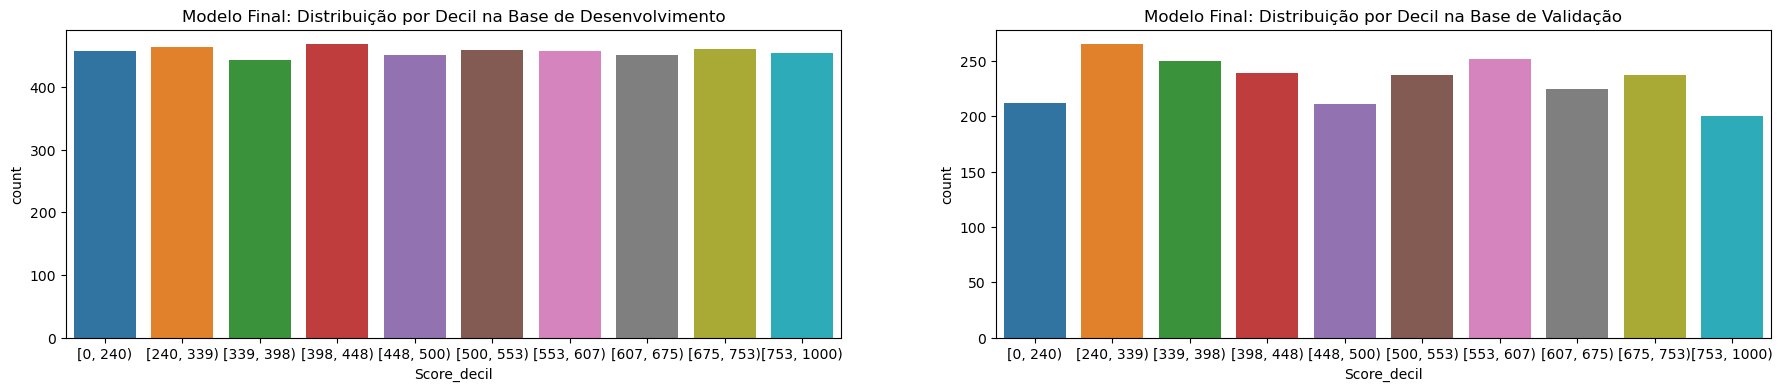

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22,4))
sns.countplot(data=df_dev,x='Score_decil', ax=ax[0]).set(title='Modelo Final: Distribuição por Decil na Base de Desenvolvimento')
sns.countplot(data=df_val,x='Score_decil', ax=ax[1]).set(title='Modelo Final: Distribuição por Decil na Base de Validação')

PSI

In [ ]:
df_psi_mf_group = pd.pivot_table(df_dev, index = ['Score_decil'], values='CLIENTE', aggfunc='sum',).reset_index()
df_psi_mf_group['QTD_CLIENTE_PERC_DEV'] = df_psi_mf_group['CLIENTE']/df_psi_mf_group['CLIENTE'].sum()

df_val_group = pd.pivot_table(df_val, index = ['Score_decil'], values='CLIENTE', aggfunc='sum',).reset_index()

df_psi_mf_group['QTD_CLIENTE_PERC_VAL'] = df_val_group['CLIENTE']/df_val_group['CLIENTE'].sum()

df_psi_mf_group['val_menos_dev'] = df_psi_mf_group['QTD_CLIENTE_PERC_VAL']-df_psi_mf_group['QTD_CLIENTE_PERC_DEV']
df_psi_mf_group['val_divido_dev'] = df_psi_mf_group['QTD_CLIENTE_PERC_VAL']/df_psi_mf_group['QTD_CLIENTE_PERC_DEV']
df_psi_mf_group['produto'] = df_psi_mf_group['val_menos_dev']*df_psi_mf_group['val_divido_dev'].apply(math.log)
df_psi_mf_group

,Score_decil,CLIENTE,QTD_CLIENTE_PERC_DEV,QTD_CLIENTE_PERC_VAL,val_menos_dev,val_divido_dev,produto
0,"[0, 240)",1578190,0.100355,0.087006,-0.013349,0.866980,0.001905
1,"[240, 339)",1583029,0.100662,0.112832,0.012170,1.120895,0.001389
2,"[339, 398)",1478162,0.093994,0.109246,0.015252,1.162267,0.002294
3,"[398, 448)",1563524,0.099422,0.096288,-0.003134,0.968478,0.000100
4,"[448, 500)",1619626,0.102990,0.089820,-0.013170,0.872123,0.001802
5,"[500, 553)",1597764,0.101599,0.111347,0.009747,1.095940,0.000893
6,"[553, 607)",1608892,0.102307,0.106747,0.004440,1.043396,0.000189
7,"[607, 675)",1519853,0.096645,0.094801,-0.001844,0.980922,0.000036
8,"[675, 753)",1573813,0.100076,0.104710,0.004634,1.046301,0.000210
9,"[753, 1000)",1603259,0.101949,0.087203,-0.014746,0.855363,0.002304


In [ ]:
df_psi_mf_group['produto'].sum()

0.011120684557403102

Análise: Como PSI está abaixo de 0.1, o modelo é considerado estável

#### Distribuição por Decil - Modelo Mercado

[Text(0.5, 1.0, 'Modelo Mercado: Distribuição por Decil na Base de Validação')]

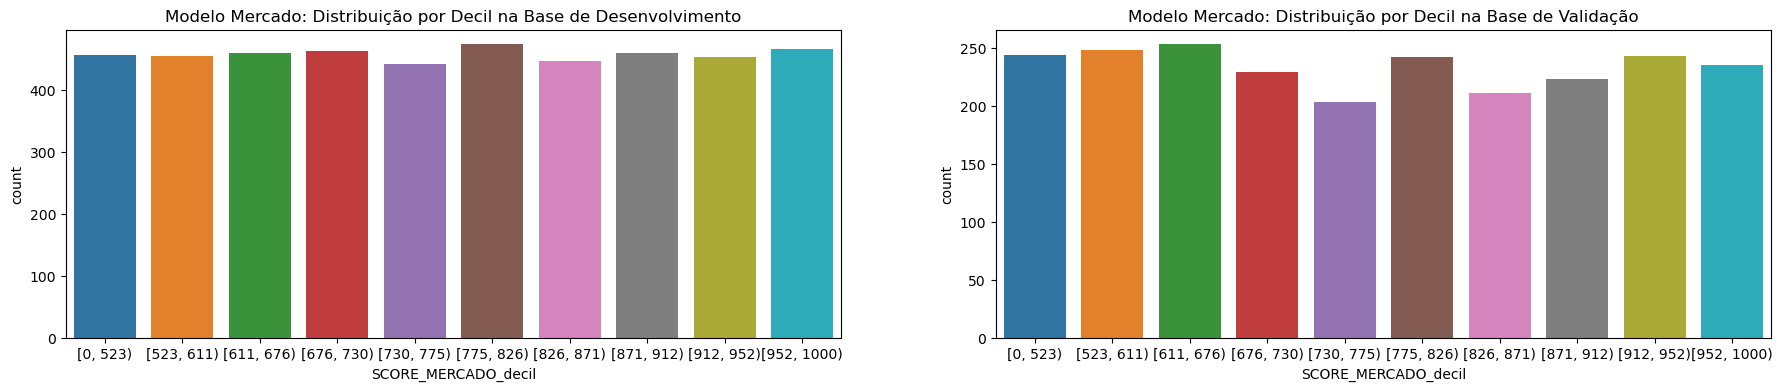

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22,4))
sns.countplot(data=df_dev,x='SCORE_MERCADO_decil', ax=ax[0]).set(title='Modelo Mercado: Distribuição por Decil na Base de Desenvolvimento')
sns.countplot(data=df_val,x='SCORE_MERCADO_decil', ax=ax[1]).set(title='Modelo Mercado: Distribuição por Decil na Base de Validação')

PSI

In [ ]:
df_psi_mf_group = pd.pivot_table(df_dev, index = ['SCORE_MERCADO_decil'], values='CLIENTE', aggfunc='sum',).reset_index()
df_psi_mf_group['QTD_CLIENTE_PERC_DEV'] = df_psi_mf_group['CLIENTE']/df_psi_mf_group['CLIENTE'].sum()

df_val_group = pd.pivot_table(df_val, index = ['SCORE_MERCADO_decil'], values='CLIENTE', aggfunc='sum',).reset_index()

df_psi_mf_group['QTD_CLIENTE_PERC_VAL'] = df_val_group['CLIENTE']/df_val_group['CLIENTE'].sum()

df_psi_mf_group['val_menos_dev'] = df_psi_mf_group['QTD_CLIENTE_PERC_VAL']-df_psi_mf_group['QTD_CLIENTE_PERC_DEV']
df_psi_mf_group['val_divido_dev'] = df_psi_mf_group['QTD_CLIENTE_PERC_VAL']/df_psi_mf_group['QTD_CLIENTE_PERC_DEV']
df_psi_mf_group['produto'] = df_psi_mf_group['val_menos_dev']*df_psi_mf_group['val_divido_dev'].apply(math.log)
df_psi_mf_group

,SCORE_MERCADO_decil,CLIENTE,QTD_CLIENTE_PERC_DEV,QTD_CLIENTE_PERC_VAL,val_menos_dev,val_divido_dev,produto
0,"[0, 523)",1556656,0.098944,0.104895,0.005950,1.060139,0.000348
1,"[523, 611)",1567394,0.099627,0.105372,0.005746,1.057671,0.000322
2,"[611, 676)",1600622,0.101739,0.109654,0.007916,1.077803,0.000593
3,"[676, 730)",1546460,0.098296,0.093472,-0.004824,0.950926,0.000243
4,"[730, 775)",1549019,0.098459,0.090285,-0.008174,0.916979,0.000708
5,"[775, 826)",1644868,0.104551,0.103452,-0.001099,0.989490,0.000012
6,"[826, 871)",1553977,0.098774,0.091062,-0.007712,0.921922,0.000627
7,"[871, 912)",1584561,0.100718,0.103947,0.003229,1.032064,0.000102
8,"[912, 952)",1532362,0.097400,0.100224,0.002824,1.028998,0.000081
9,"[952, 1000)",1596749,0.101493,0.097636,-0.003857,0.962002,0.000149


In [ ]:
df_psi_mf_group['produto'].sum()

0.0031845380402558466

Análise: Como PSI está abaixo de 0.1, o modelo é considerado estável

#### Inadimplência por Decil - Modelo Final

[Text(0.5, 1.0, 'Modelo Final: Inadimplência por Decil na Base de Validação')]

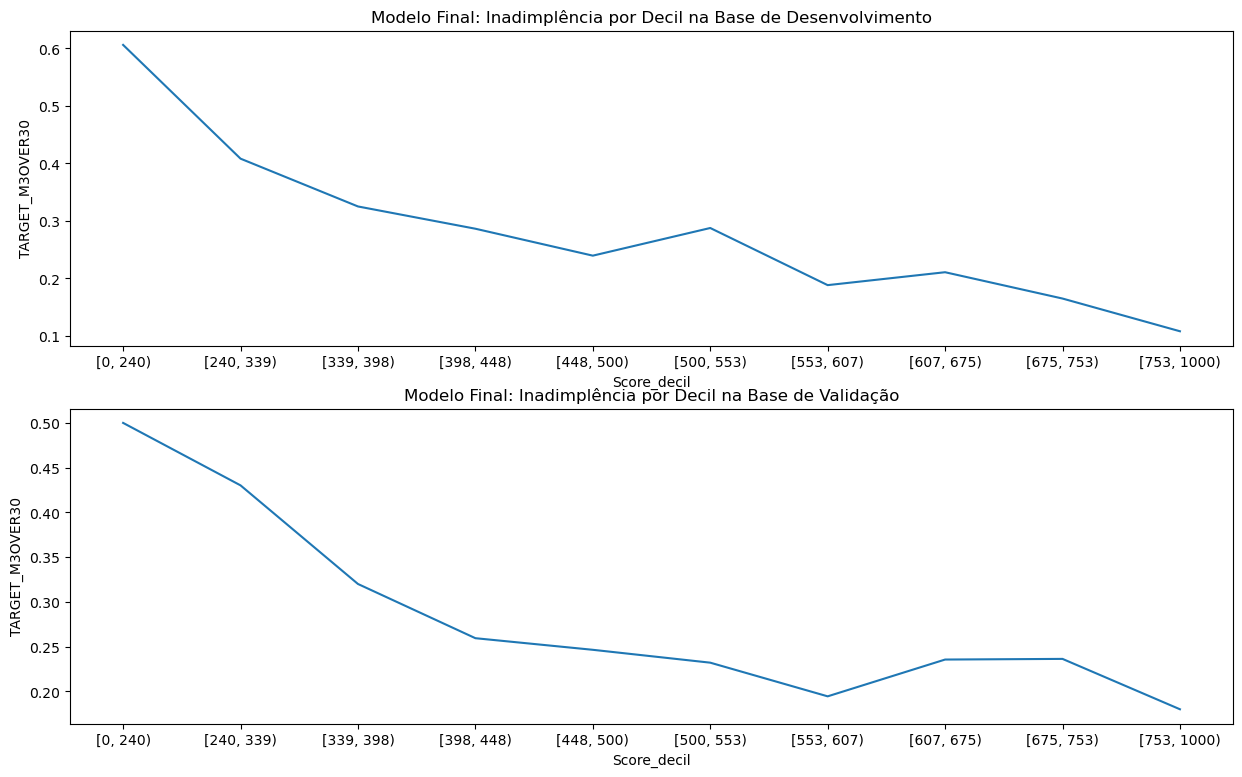

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,9))

df_pivot_dev = pd.pivot_table(df_dev, index = ['Score_decil'], values='TARGET_M3OVER30', aggfunc='mean')
df_pivot_dev['Score_decil'] = [str(interval) for interval in df_pivot_dev.index.categories]
sns.lineplot(data=df_pivot_dev,x='Score_decil', y='TARGET_M3OVER30', ax=ax[0]).set(title='Modelo Final: Inadimplência por Decil na Base de Desenvolvimento')

df_pivot_val = pd.pivot_table(df_val, index = ['Score_decil'], values='TARGET_M3OVER30', aggfunc='mean')
df_pivot_val['Score_decil'] = [str(interval) for interval in df_pivot_val.index.categories]
sns.lineplot(data=df_pivot_val,x='Score_decil', y='TARGET_M3OVER30', ax=ax[1]).set(title='Modelo Final: Inadimplência por Decil na Base de Validação')

In [ ]:
print('Inadimplência Mínima e Máxima: Base Desenvolvimento', round(df_pivot_dev['TARGET_M3OVER30'].min(),1), round(df_pivot_dev['TARGET_M3OVER30'].max(),1))
print('Inadimplência Mínima e Máxima: Base Validação', round(df_pivot_val['TARGET_M3OVER30'].min(),1), round(df_pivot_val['TARGET_M3OVER30'].max(),1))

Inadimplência Mínima e Máxima: Base Desenvolvimento 0.1 0.6
Inadimplência Mínima e Máxima: Base Validação 0.2 0.5


#### Inadimplência por Decil - Modelo Mercado

[Text(0.5, 1.0, 'Modelo Mercado: Inadimplência por Decil na Base de Validação')]

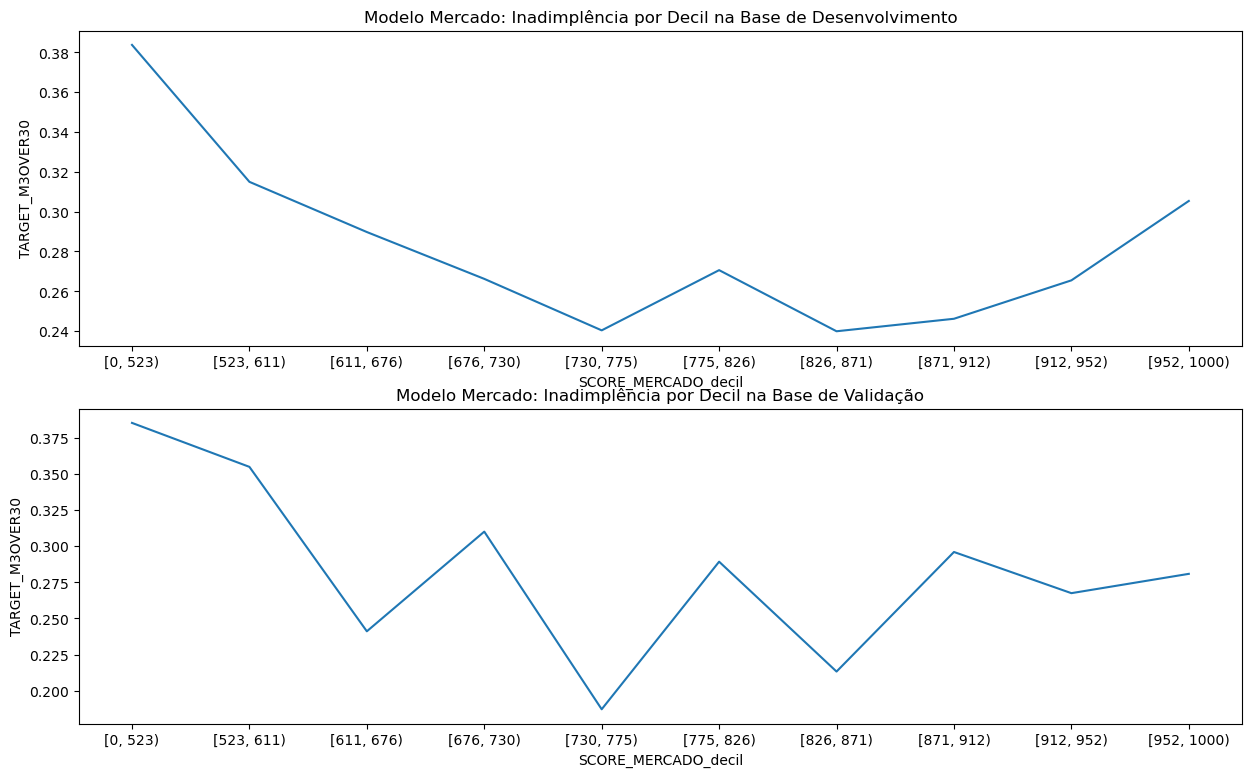

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,9))

df_pivot_dev = pd.pivot_table(df_dev, index = ['SCORE_MERCADO_decil'], values='TARGET_M3OVER30', aggfunc='mean')
df_pivot_dev['SCORE_MERCADO_decil'] = [str(interval) for interval in df_pivot_dev.index.categories]
sns.lineplot(data=df_pivot_dev,x='SCORE_MERCADO_decil', y='TARGET_M3OVER30', ax=ax[0]).set(title='Modelo Mercado: Inadimplência por Decil na Base de Desenvolvimento')

df_pivot_val = pd.pivot_table(df_val, index = ['SCORE_MERCADO_decil'], values='TARGET_M3OVER30', aggfunc='mean')
df_pivot_val['SCORE_MERCADO_decil'] = [str(interval) for interval in df_pivot_val.index.categories]
sns.lineplot(data=df_pivot_val,x='SCORE_MERCADO_decil', y='TARGET_M3OVER30', ax=ax[1]).set(title='Modelo Mercado: Inadimplência por Decil na Base de Validação')

In [ ]:
print('Inadimplência Mínima e Máxima: Base Desenvolvimento', round(df_pivot_dev['TARGET_M3OVER30'].min(),1), round(df_pivot_dev['TARGET_M3OVER30'].max(),1))
print('Inadimplência Mínima e Máxima: Base Validação', round(df_pivot_val['TARGET_M3OVER30'].min(),1), round(df_pivot_val['TARGET_M3OVER30'].max(),1))

Inadimplência Mínima e Máxima: Base Desenvolvimento 0.2 0.4
Inadimplência Mínima e Máxima: Base Validação 0.2 0.4


Análise: O modelo final ordena melhor do que o modelo de mercado, isto é, a curva de inadimplência é decrescente e não há tantas inversões como ocorre no modelo de mercado, principalmente na base de validação.
Além disso, a amplitude das curvas de inadimplência por decil do modelo final é maior do que as respectivas curvas no modelo de mercado. Isso significa que, usando o modelo final, para uma mesma volumetria é possível recusar um grupo pior e aprovar um grupo melhor de propostas

### Extração Base

In [ ]:
df_dev['Base']='desenvolvimento'
df_val['Base']='validacao'
base_final = pd.concat([df_dev, df_val])

In [ ]:
base_final.to_csv('base_final.csv',index=False, sep=';')

### Conclusões Finais

Análise: Percebe-se que o Modelo Final ordenou bem os decis, isto é, quanto maior a faixa de score menor a inadimplência. O mesmo ocorre na base de validação, embora com alguma inversão. O Modelo Final atingiu KS=20,4% enquanto que o Modelo de Mercado está com KS=9%.  
O Modelo Final consegue ser muito mais eficiente quando comparado ao modelo de mercado, não apenas por conta das inversões que ocorre nesse último com mais frequência, mas também pela amplitude da taxa de inadimplência entre a melhor e a pior faixa de score. Isso significa que com o score do modelo final, considerando apenas a base de propostas formalizadas, seria possível aprovar mais propostas mantendo a mesma inadimplência.
